# **АНАЛИЗ ДАННЫХ КЛИЕНТСКИХ СЕССИЙ СЕРВИСА 'СберАвтоподписка'**

---

Цели и задачи работы:
 
*   1) Data understanding (изучить данные,  выявить их связь с реальными процессами) и Data preparation (подготовка данных для проведения обучения моделей: оценить чистоту и полноту данных, дубликаты, пустые значения, типизация данных, ненужные атрибуты, анализ ключевых распределений данных и их взаимосвязей) 

*   2) Data modelling Предсказание совершение целевого действия(ориентировочное значение ROC-AUC ~ 0.65) — факт совершения пользователей целевого действия.

*   3) Deployment Упаковка получившейся модели в сервис, который будет брать на вход все атрибуты, типа utm_*, device_*, geo_*, и отдавать на выход 0/1 (1 — если пользователь совершит любое целевое действие)

*   4) Подговка получившихся артефактов, проверка их на соответствие итоговым критериям оценки 



---

Описание датасет df_sessions

session_id — ID визита;
client_id — ID посетителя;
visit_date — дата визита;
visit_time — время визита;
visit_number — порядковый номер визита клиента;
utm_source — канал привлечения;
utm_medium — тип привлечения;
utm_campaign — рекламная кампания;
utm_keyword — ключевое слово;
device_category — тип устройства;
device_os — ОС устройства;
device_brand — марка устройства;
device_model — модель устройства;
device_screen_resolution — разрешение экрана;
19device_brand — марка устройства;
device_model — модель устройства;
device_screen_resolution — разрешение экрана;
device_browser — браузер;
geo_country — страна;
geo_city — город.




Описание датасет df_hits

session_id — ID визита;
hit_date — дата события;
hit_time — время события;
hit_number — порядковый номер события в рамках сессии;
hit_type — тип события;
hit_referer — источник события;
hit_page_path — страница события;
event_category — тип действия;
event_action — действие;
event_label — тег действия;
event_value — значение результата действия.


# **1. DATA UNDERSTANDING & DATA PREPARATION**

---



## **ИМПОРТ БИБЛИОТЕК**

---

In [1]:
!pip install scipy==1.7.1
!pip install jupyterthemes

import scipy
import sys
from datetime import datetime
import warnings
from pathlib import Path
from typing import Union
from functools import partial
import time
import os
import warnings
warnings.filterwarnings('ignore')



from matplotlib import pyplot
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
import pandas as pd


import pickle

from typing import Sequence, Union
import os


## **ЗАГРУЗКА И ОЦЕНКА ДАТАСЕТ**


---

In [2]:
# подготовим абсолютный путь до папки с данными
path = os.path.expanduser('~/PycharmProjects/FinalFantasyProj/')
path

start = time.time() # включим таймер для подсчета времени чтения файла в датасет

df_hits = pd.read_csv(path + 'ga_hits.csv')
elapsed_time = time.time() - start # зафиксируем время чтения файла в датасет
print(f'Датасет событий успешно прочитан из файла ga_hits.csv, \nРазмеры датасета: {df_hits.shape}, \nВремя чтения файла в датасет: {elapsed_time:.3f}')
#df.shape

Датасет событий успешно прочитан из файла ga_hits.csv, 
Размеры датасета: (15726470, 11), 
Время чтения файла в датасет: 26.516


## **АНАЛИЗ ДАТАСЕТ GA_HITS.CSV**


---

В датасете ga_hits.csv содержатся данные о событиях в рамках каждой сессии из другого датасета ga_sessions.csv.

Размеры датасета ga_hits.csv: 15 726 470 строк × 11 колонок. В датасетах собраны события в рамках одного визита за период с 2021-05-19 по 2021-12-31. Это данные с начала запуска сервиса 'СберАвтоподписка' до конца 2021 года.

Дубликаты есть. удалим

### Размер выборки 

In [3]:
# Описания датосетa
df_hits.info()
#размер выборки  
print('Размер выбоpки df_hits: {}, {}'.format(df_hits.shape[0], df_hits.shape[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB
Размер выбоpки df_hits: 15726470, 11


### Дубликаты и пропуски в df_hits

*   Есть пропуски (event_value, hit_time, hit_referer) > 58%  удаляются.
*   Есть пропуски (event_label) < 40% - будут заполняться самым встречающимся значение. 








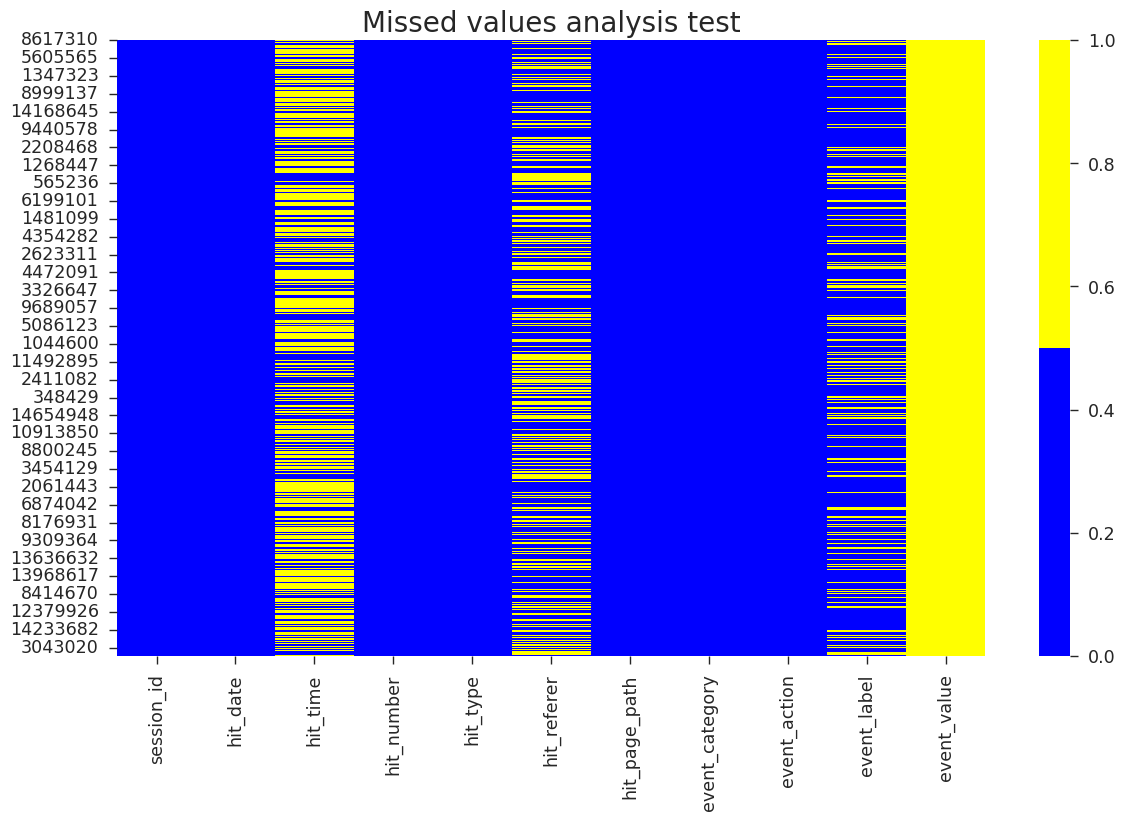

In [4]:
from jupyterthemes import jtplot
jtplot.style(context='notebook', ticks=True, grid=False)

plt.figure(figsize=(14, 8))
plt.title('Missed values analysis test', fontsize=20)
sns.heatmap(df_hits.sample(2000).isnull(), cmap=sns.color_palette(['blue', 'yellow']))
plt.show()

In [5]:

print(f'Количество дубликатов в df_ga_hits: {df_hits.duplicated().sum()}') 
#print(f'Количество пропусков в df_ga_hits: {df_hits.isna().sum()}') 
missing_values = ((df_hits.isna().sum() / len(df_hits)) * 100).sort_values()
print('Процент пропущенных значений до удаления столбцов:', missing_values)
df_hits2 = df_hits.drop(['event_value', 'hit_time', 'hit_referer'], axis=1)
missing_values = ((df_hits2.isna().sum() / len(df_hits2)) * 100).sort_values()
print('Процент пропущенных значений до удаления столбцов:', missing_values)

Количество дубликатов в df_ga_hits: 0
Процент пропущенных значений до удаления столбцов: session_id          0.000000
hit_date            0.000000
hit_number          0.000000
hit_type            0.000000
hit_page_path       0.000000
event_category      0.000000
event_action        0.000000
event_label        23.909905
hit_referer        39.899634
hit_time           58.247795
event_value       100.000000
dtype: float64
Процент пропущенных значений до удаления столбцов: session_id         0.000000
hit_date           0.000000
hit_number         0.000000
hit_type           0.000000
hit_page_path      0.000000
event_category     0.000000
event_action       0.000000
event_label       23.909905
dtype: float64


In [6]:
print(f'размер выборки: {df_hits2.shape}') 
print(f'Количество дубликатов в df_ga_hits: {df_hits2.duplicated().sum()}') 
df_hits2 = df_hits2.drop_duplicates()
print(f'Количество дубликатов в df_ga_hits: {df_hits2.duplicated().sum()}') 
print(f'размер выборки: {df_hits2.shape}') 

размер выборки: (15726470, 8)
Количество дубликатов в df_ga_hits: 37754
Количество дубликатов в df_ga_hits: 0
размер выборки: (15688716, 8)


### Hit_date — дата события

Количество уникальных значений в `hit_date`: 226
размер выборки: (15688716, 8)


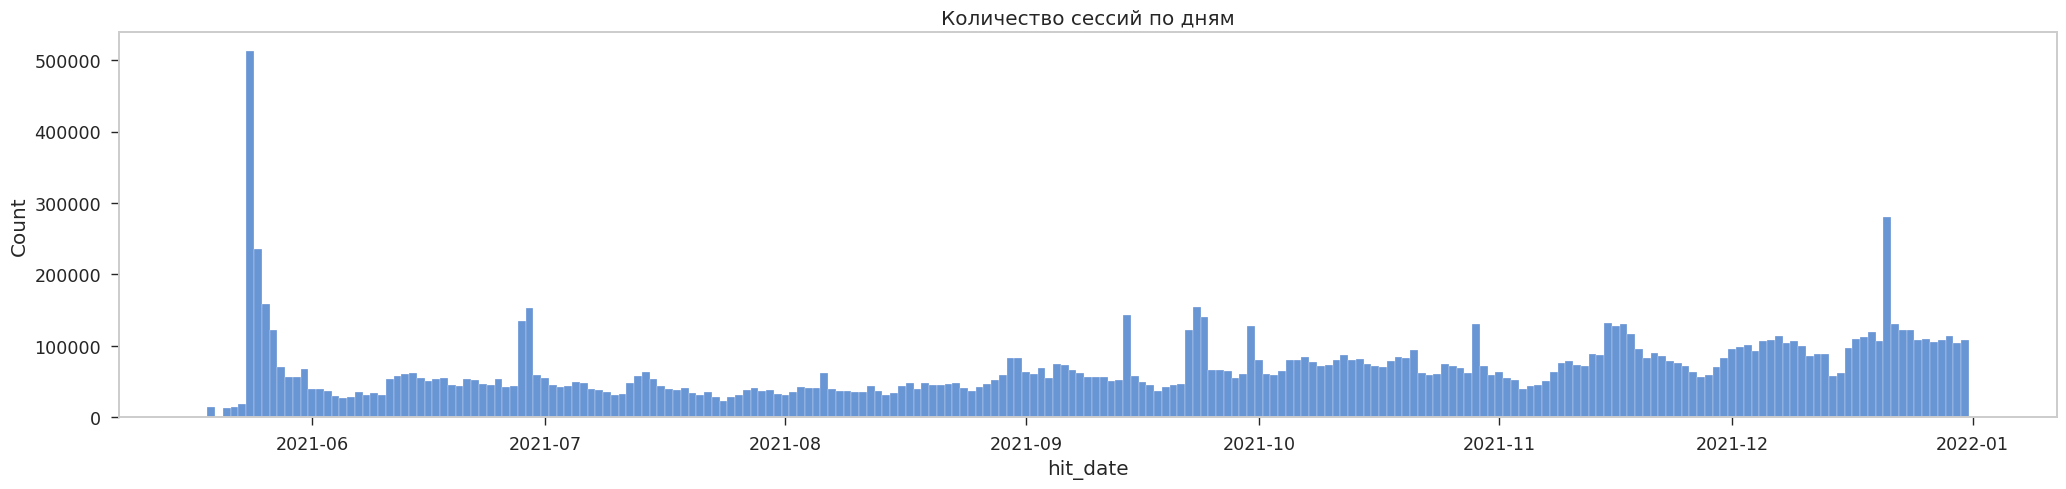

In [7]:
# переведем формат в дату
df_hits2['hit_date'] = pd.to_datetime(df_hits2.hit_date, utc=True)
n_unique = df_hits2['hit_date'].nunique()
print(f'Количество уникальных значений в `hit_date`: {n_unique}')
df_hits2['hit_date'].describe(datetime_is_numeric=True) 
plt.figure(figsize=(25, 5))
sns.histplot(df_hits2, x='hit_date', discrete=True)
plt.title('Количество сессий по дням');
# распределение сессий за день
print(f'размер выборки: {df_hits2.shape}') 

### Visit_date_weekday - день недели 
Для того, чтобы проанализировать количество посещений по дням, создадим новый признак - день недели 

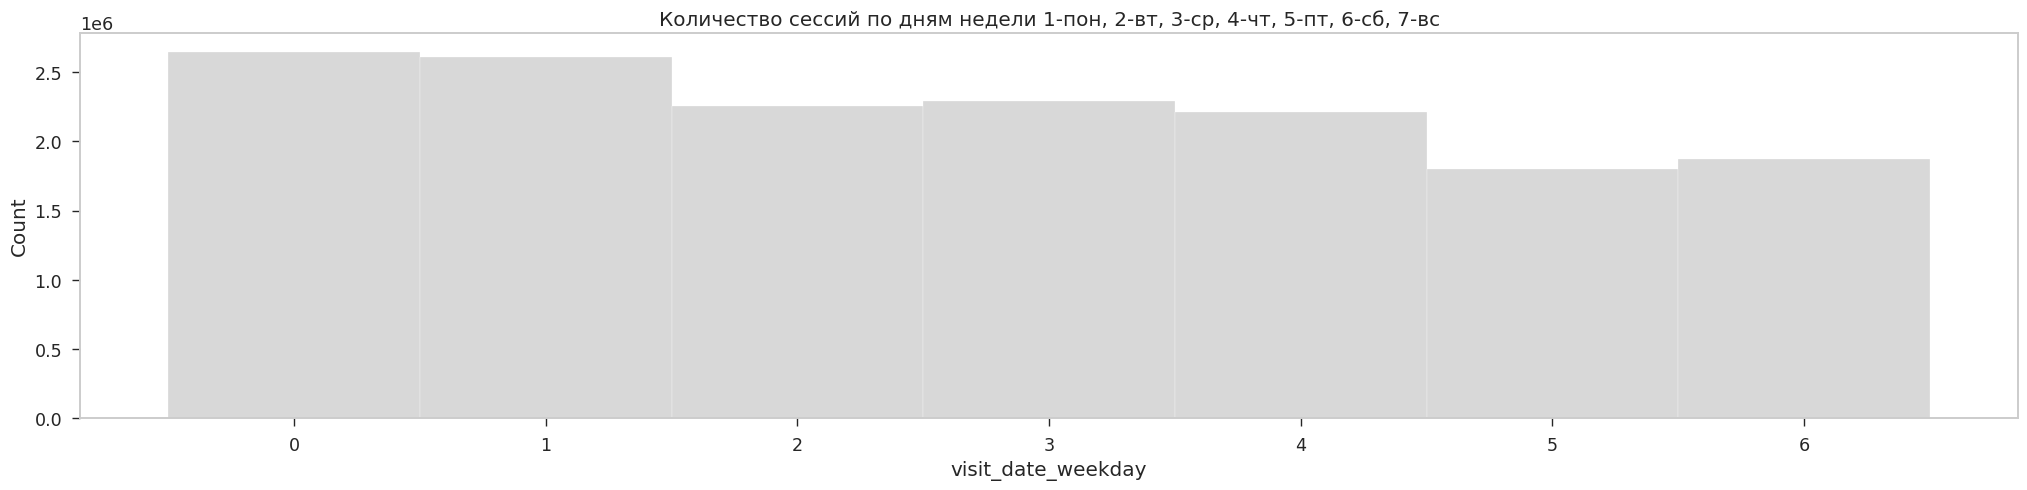

In [8]:
df_hits2['visit_date_weekday'] = df_hits2['hit_date'].dt.day_of_week
plt.figure(figsize=(25, 5))
sns.histplot(data=df_hits2, x='visit_date_weekday', discrete=True)
plt.title('Количество сессий по дням недели 1-пон, 2-вт, 3-ср, 4-чт, 5-пт, 6-сб, 7-вс');

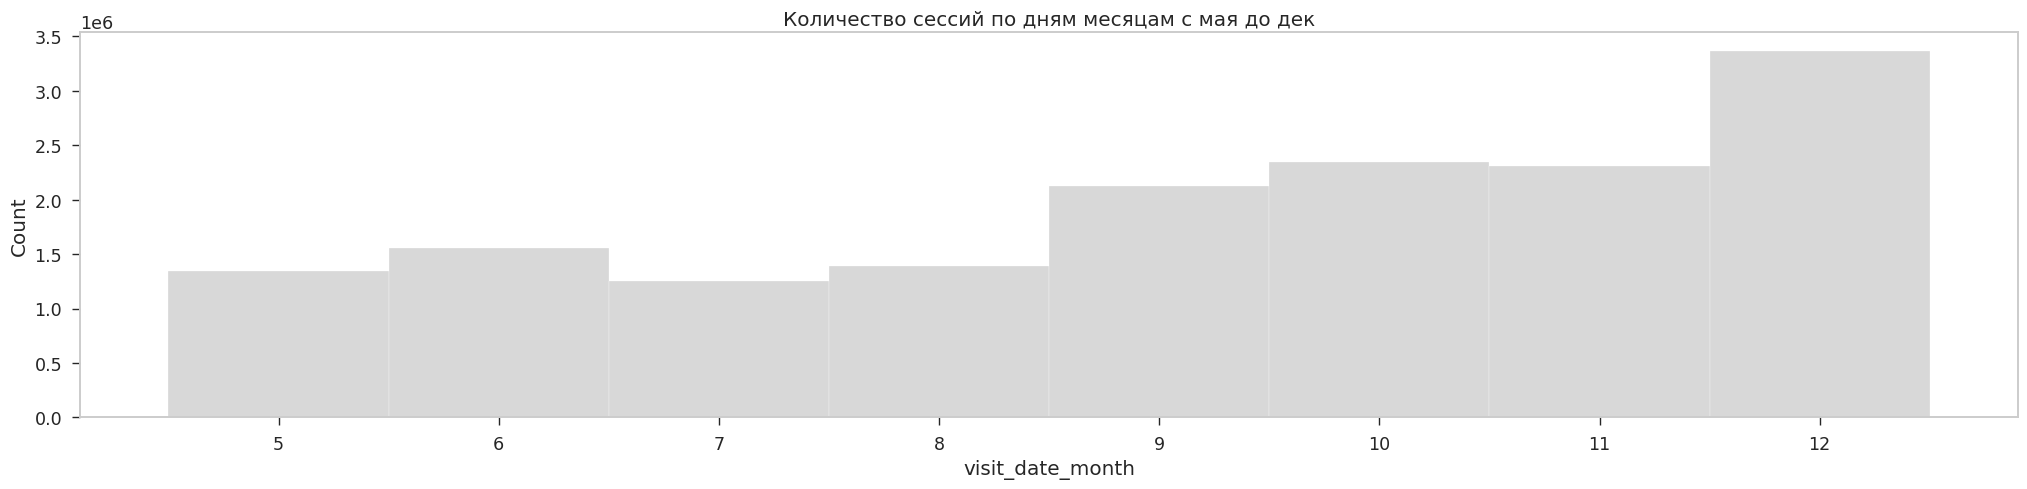

In [9]:
df_hits2['visit_date_month'] = df_hits2['hit_date'].dt.month
plt.figure(figsize=(25, 5))
sns.histplot(data=df_hits2, x='visit_date_month', discrete=True)
plt.title('Количество сессий по дням месяцам с мая до дек');

### Hit_number (порядковый номер события в рамках сессии) 

Количество уникальных значений в `hit_date`: 500


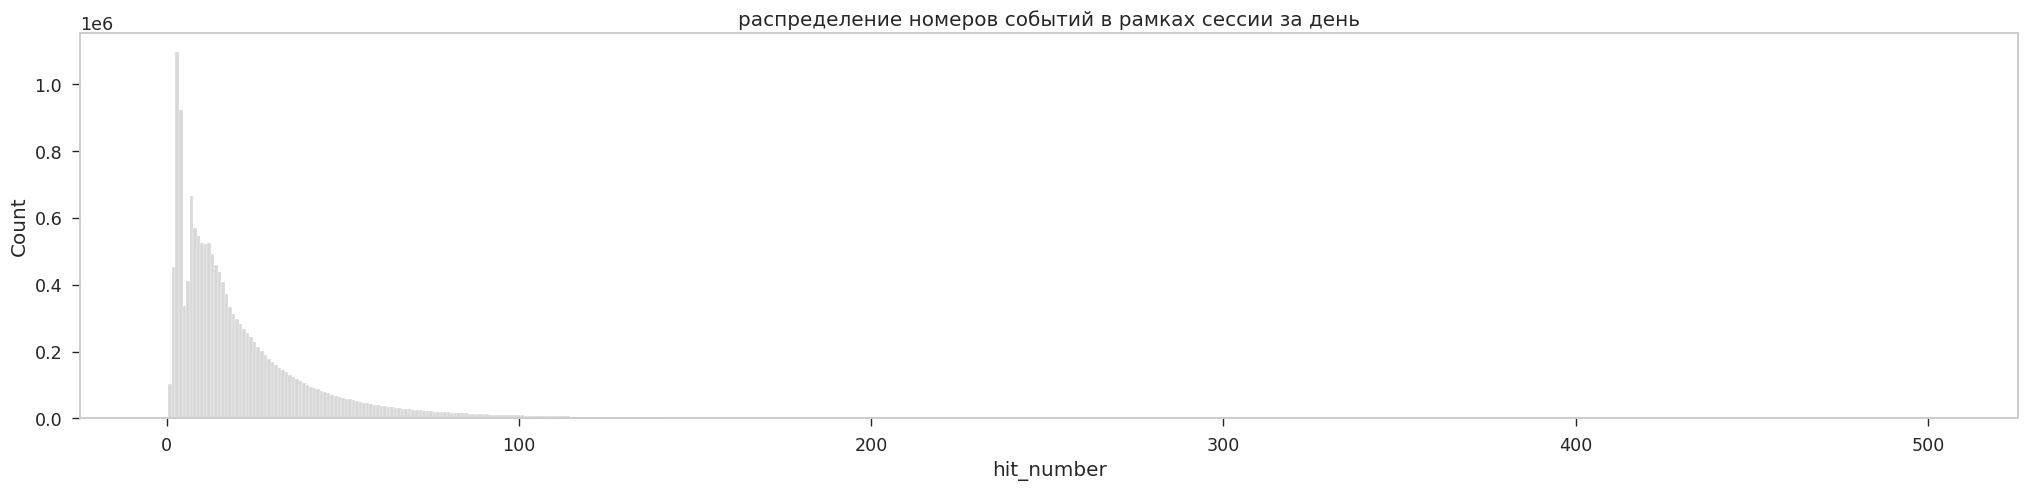

In [10]:
n_unique2=df_hits2['hit_number'].nunique()
print(f'Количество уникальных значений в `hit_date`: {n_unique2}')
plt.figure(figsize=(25, 5))
sns.histplot(df_hits2, x='hit_number', discrete=True)
plt.title('распределение номеров событий в рамках сессии за день');
# распределение номеров событий в рамках сессии за день

In [11]:
df_hits2['hit_number'].describe().apply(lambda x: f'{x:0.1f}')
print(f'размер выборки: {df_hits2.shape}') 

размер выборки: (15688716, 10)


### Hit_type (тип события)  
уникальных значений 1. смысловой нагрузки столбец не несет. можно его удалить, чтобы не занимал место

In [12]:
print('кол-во уникальных значений', df_hits2['hit_type'].nunique())
print('уникальные значения', df_hits2['hit_type'].unique())
df_hits2 = df_hits2.drop(['hit_type'], axis=1)
print(f'размер выборки: {df_hits2.shape}') 

кол-во уникальных значений 1
уникальные значения ['event']
размер выборки: (15688716, 9)


### Hit_page_path (страница события) 
кол-во уникальных значений 342715

In [13]:
df_hits2 = df_hits2[df_hits2["hit_page_path"].str.contains("podpiska") == False]
df_hits2 = df_hits2[df_hits2["hit_page_path"].str.contains("client") == False]
df_hits2 = df_hits2.drop (index=[0 , 1 , 3, 5, 6])
print(f'размер выборки: {df_hits2.shape}') 

размер выборки: (12462536, 9)


In [14]:
split2 = df_hits2['hit_page_path'].str.split('sberauto.com/cars/all/', expand=True)
df_hits2[['hit_page_path_0', 'model_car']] = split2
df_hits2=df_hits2.drop(columns = ['hit_page_path_0'],axis = 1)

In [15]:
split2 = df_hits2['model_car'].str.split('/', expand=True)
df_hits2[['car_brand', 'car_model', '2', '3', '4']] = split2
df_hits2=df_hits2.drop(columns = ['2', '3', '4'],axis = 1)
df_hits2[['car_brand', 'car_model']].head(5)
# удалим ненужный столбец
df_hits2=df_hits2.drop(columns = ['model_car'],axis = 1)
print(f'размер выборки: {df_hits2.shape}') 

размер выборки: (12462536, 11)


In [16]:
print('наиболее частые значения', df_hits2[['car_brand', 'car_model']].describe())
print(f'Количество пропусков в df_ga_hits: {df_hits2.isna().sum()}')

наиболее частые значения        car_brand car_model
count    3378267   3378267
unique        18        66
top        skoda     rapid
freq      740950    439312
Количество пропусков в df_ga_hits: session_id                  0
hit_date                    0
hit_number                  0
hit_page_path               0
event_category              0
event_action                0
event_label           2844200
visit_date_weekday          0
visit_date_month            0
car_brand             9084269
car_model             9084269
dtype: int64


In [17]:
# а) заполним их наиболее частым встречающимся значением ()
df_hits2.car_brand = df_hits2.car_brand.fillna('skoda')
df_hits2.car_model = df_hits2.car_model.fillna('rapid')
print(df_hits2.shape)

(12462536, 11)


In [18]:
df_hits2.car_brand.value_counts()

skoda            9825219
mercedes-benz     470823
volkswagen        412627
lada-vaz          399189
kia               235281
nissan            233902
bmw               188282
toyota            160170
renault           147565
porsche            63029
lexus              61596
audi               60022
volvo              51570
haval              51522
mini               34709
peugeot            27170
land-rover         24630
hyundai            15230
Name: car_brand, dtype: int64

In [19]:
car_brand_filter = ['skoda', 'mercedes-benz', 'volkswagen', 'lada-vaz', 'kia', 'nissan', 'bmw']
filter = (df_hits2['car_brand'].isin(car_brand_filter)) & (df_hits2['hit_number']<80)
df_hits_filtered_car_brand = df_hits2[filter]
df_hits_filtered_car_brand.shape

(11241672, 11)

Средние значения car_brand
bmw              27.047588
kia              29.354621
lada-vaz         19.911742
mercedes-benz    22.663158
nissan           20.297879
skoda            22.004968
volkswagen       23.302026
Name: hit_number, dtype: float64


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'volkswagen'),
  Text(1, 0, 'mercedes-benz'),
  Text(2, 0, 'nissan'),
  Text(3, 0, 'skoda'),
  Text(4, 0, 'bmw'),
  Text(5, 0, 'lada-vaz'),
  Text(6, 0, 'kia')])

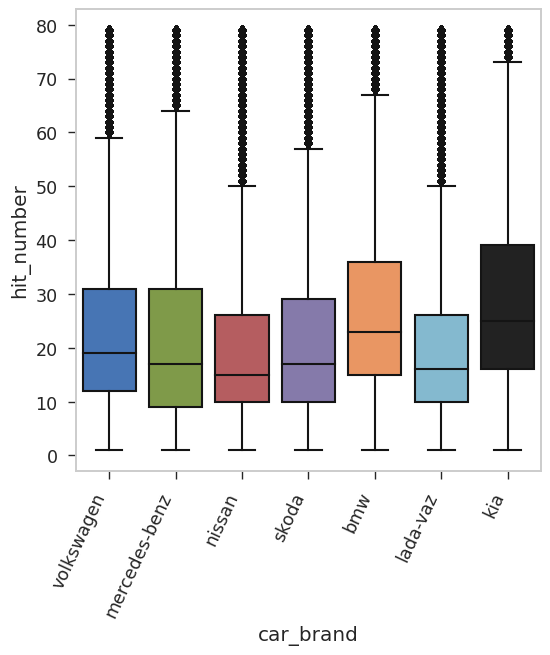

In [20]:
print('Средние значения', df_hits_filtered_car_brand.groupby('car_brand')['hit_number'].mean())
f, ax = plt.subplots(figsize=(6, 6))
fig = sns.boxplot(x='car_brand', y='hit_number', data=df_hits_filtered_car_brand)
plt.xticks(rotation=65, ha = 'right')

In [21]:
print(f'Количество пропусков в df_ga_hits: {df_hits2.isna().sum()}')
print(f'Количество дубликатов в df_ga_hits: {df_hits2.duplicated().sum()}') 

Количество пропусков в df_ga_hits: session_id                  0
hit_date                    0
hit_number                  0
hit_page_path               0
event_category              0
event_action                0
event_label           2844200
visit_date_weekday          0
visit_date_month            0
car_brand                   0
car_model                   0
dtype: int64
Количество дубликатов в df_ga_hits: 0


### Event_category (тип действия) 
кол-во уникальных значений 45
в топ-5 след
card_web           7414467
search_form        2407253
listing_ads         819877
cars                358177
sap_search_form     355129

In [22]:
print('кол-во уникальных значений', df_hits2['event_category'].nunique())
df_hits2.event_category.value_counts().head(5)

кол-во уникальных значений 45


card_web           7414467
search_form        2407253
listing_ads         819877
cars                358177
sap_search_form     355129
Name: event_category, dtype: int64

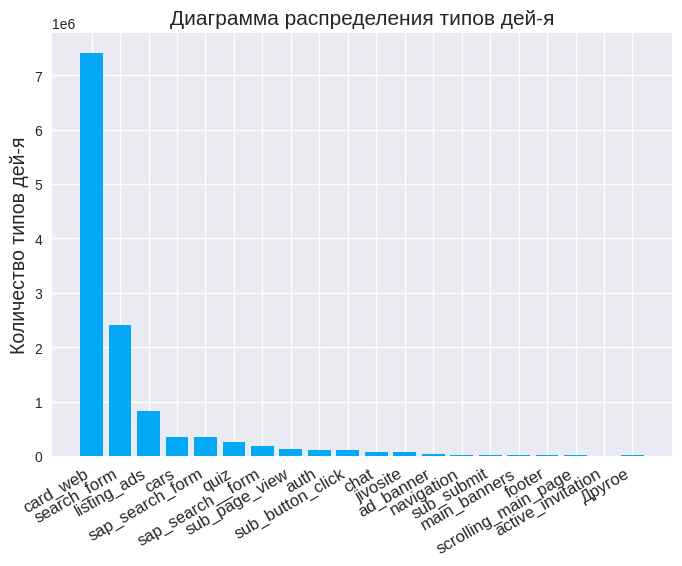

In [23]:
import matplotlib.pyplot as plt

type_counts = df_hits2['event_category'].value_counts()

other_types = type_counts[type_counts<8000]
type_counts = type_counts[type_counts>8000]
type_counts['Другое'] = other_types.sum() # Замена редких значений категорией Другое

plt.style.use('seaborn') # Смена стиля всех графиков matplotlib

params = {
          'axes.titlesize': 15,   # Размер шрифта главной подписи
          'xtick.labelsize': 12,  # Размер шрифта подписей тикетов оси X
          'axes.labelsize': 14    # Размер шрифта подписей осей
          }
plt.rcParams.update(params) # Фиксация параметров

plt.ylabel('Количество типов дей-я') # Подпись оси Y
plt.title('Диаграмма распределения типов дей-я') # Подпись всего графика

plt.xticks(rotation=30, ha = 'right') # Поворот на 30 градусов подписей оси X и выравнивание по правому краю

plt.bar(type_counts.index, type_counts.values, color='#03A9F4') # Кастомизация цвета
plt.show()

 ### Event_action (действие)

Целевые действия находятся в event_action. Всего уникальных событий - 210. 
Больше всего нецелевых событий. Продукт новый, высокостоимостной, пользователи активно его изучают. Они активно кликают по галерее с предложениями.

view_new_card             3531821
go_to_car_card             753216
search_form_region         508634
search_form_search_btn     430218


Максимальное число событий в сессию - 768, которая имело место 2021-09-24. Такое большое количество 
встречается очень редко. В-основном, чаще всего встечаются от 1 до 50 событий в сессию.

Всего целевых действий = 74140 из 12462536 что составляет  0.59 %





In [24]:
print('описание', df_hits2['event_action'].describe())
print('кол-во уникальных значений', df_hits2['event_action'].value_counts().head(5))


описание count      12462536
unique          210
top       view_card
freq        3538087
Name: event_action, dtype: object
кол-во уникальных значений view_card                 3538087
view_new_card             3531821
go_to_car_card             753216
search_form_region         508634
search_form_search_btn     430218
Name: event_action, dtype: int64


████████████████████████████████████████████████████████████████

Всего целевых действий = 74140 из 12462536 что составляет  0.59 %

sub_car_claim_click = 36364 === 0.29 %
sub_submit_success = 14484 === 0.12 %
sub_car_claim_submit_click = 11931 === 0.1 %
sub_open_dialog_click = 6831 === 0.05 %
sub_car_request_submit_click = 1975 === 0.02 %
sub_call_number_click = 1372 === 0.01 %
sub_callback_submit_click = 1174 === 0.01 %
sub_custom_question_submit_click = 9 === 0.0 %


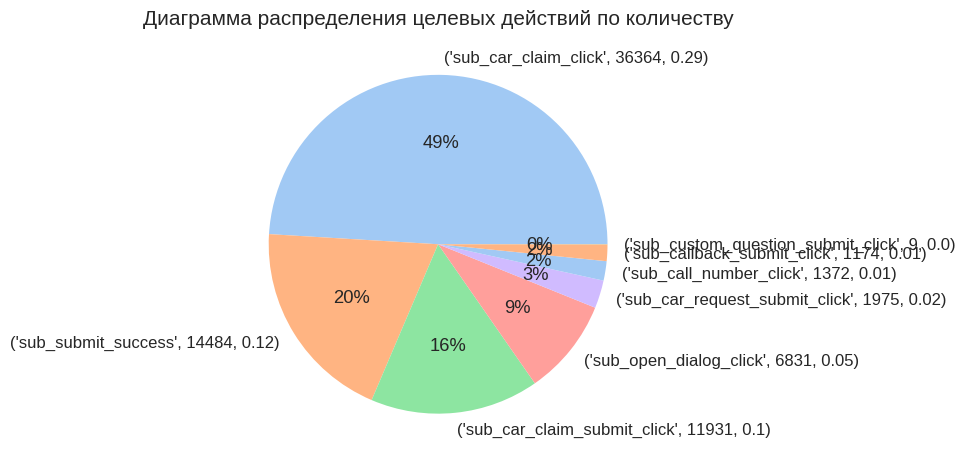

In [25]:
# Cреди многообразия действий (210 вариантов), целевыми являются только 8 (заданы по условию задания) 
#"Заказать звонок", "Оставить заявку"



all_targets = ['sub_car_claim_click', 
               'sub_car_claim_submit_click',
               'sub_open_dialog_click', 
               'sub_custom_question_submit_click',
               'sub_call_number_click', 
               'sub_callback_submit_click', 
               'sub_submit_success',
               'sub_car_request_submit_click']

sorted_all_targets = []
total = 0
i = 0
labels, data = [], []

for targets_name in all_targets:
    
    value = len(df_hits2[df_hits2['event_action'] == targets_name])
    percent = round(value/len(df_hits2)*100, 2)
    sorted_all_targets.append((targets_name, value, percent))
    
    total += value
    
    i += 1
    print("████████", end='')
    #print(targets_name, '=', value, f"=== {percent}%")
#print("█", end='')
sorted_all_targets = sorted(sorted_all_targets, key=lambda sorted_all_targets: sorted_all_targets[1],  reverse=True)
print(f'\n\nВсего целевых действий = {total} из {len(df_hits2)} что составляет {total/len(df_hits2)*100: .2f} %\n')
for target in sorted_all_targets:
    data.append(target[1])
    labels.append(target)
    print(target[0], '=', target[1], '===', target[2], '%')   

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[ 0:5 ]

#create pie chart

#plt.figure(figsize=(8, 8))
plt.title("Диаграмма распределения целевых действий по количеству")
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

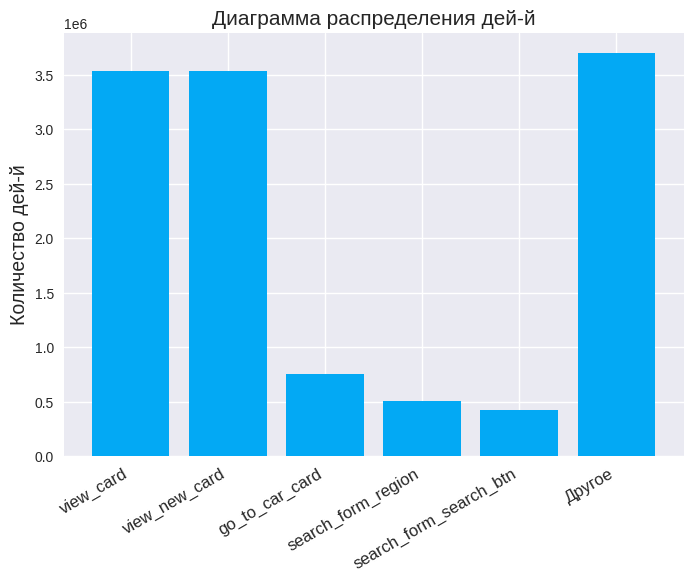

In [26]:
import matplotlib.pyplot as plt

type_counts = df_hits2['event_action'].value_counts()

other_types = type_counts[type_counts<360000]
type_counts = type_counts[type_counts>360000]
type_counts['Другое'] = other_types.sum() # Замена редких значений категорией Другое

plt.style.use('seaborn') # Смена стиля всех графиков matplotlib

params = {
          'axes.titlesize': 15,   # Размер шрифта главной подписи
          'xtick.labelsize': 12,  # Размер шрифта подписей тикетов оси X
          'axes.labelsize': 14    # Размер шрифта подписей осей
          }
plt.rcParams.update(params) # Фиксация параметров

plt.ylabel('Количество дей-й') # Подпись оси Y
plt.title('Диаграмма распределения дей-й') # Подпись всего графика

plt.xticks(rotation=30, ha = 'right') # Поворот на 30 градусов подписей оси X и выравнивание по правому краю

plt.bar(type_counts.index, type_counts.values, color='#03A9F4') # Кастомизация цвета
plt.show()

### Event_label (тег действия) - в данной колонке есть пропуски
 поступи 2мя способами:


*   а) заполним их наиболее частым встречающимся значением (KclpemfoHstknWHFiLit)
*   б) удалим пропуски, посмотрим какой датасет в модели в дальнейшем будет лучше по точности




In [27]:
print('уникальные значения', df_hits2['event_label'].describe())

уникальные значения count                  9618336
unique                   39757
top       KclpemfoHstknWHFiLit
freq                   5327845
Name: event_label, dtype: object


In [28]:
# а) заполним их наиболее частым встречающимся значением (KclpemfoHstknWHFiLit)
df_hits2.event_label = df_hits2.event_label.fillna('KclpemfoHstknWHFiLit')


In [29]:
print(f'Количество пропусков в df_ga_hits: {df_hits2.isna().sum()}')
print(f'Количество дубликатов в df_ga_hits: {df_hits2.duplicated().sum()}') 

Количество пропусков в df_ga_hits: session_id            0
hit_date              0
hit_number            0
hit_page_path         0
event_category        0
event_action          0
event_label           0
visit_date_weekday    0
visit_date_month      0
car_brand             0
car_model             0
dtype: int64
Количество дубликатов в df_ga_hits: 165780


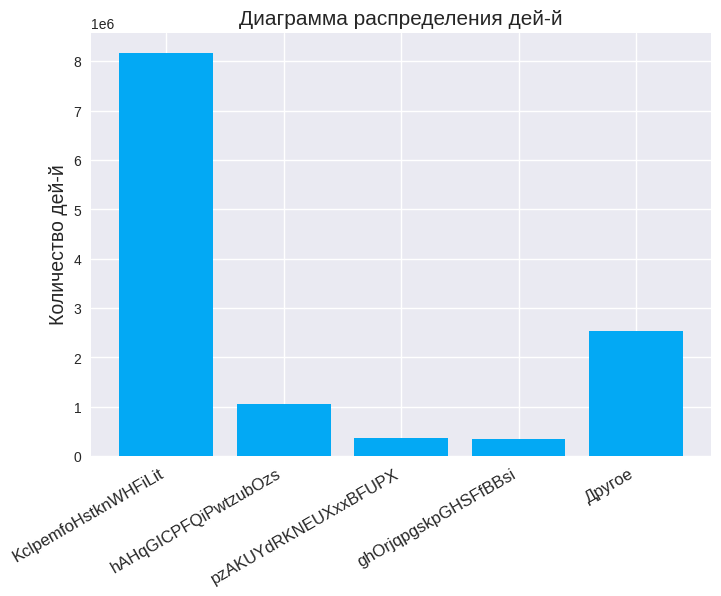

In [30]:
import matplotlib.pyplot as plt

type_counts = df_hits2['event_label'].value_counts()

other_types = type_counts[type_counts<260000]
type_counts = type_counts[type_counts>260000]
type_counts['Другое'] = other_types.sum() # Замена редких значений категорией Другое

plt.style.use('seaborn') # Смена стиля всех графиков matplotlib

params = {
          'axes.titlesize': 15,   # Размер шрифта главной подписи
          'xtick.labelsize': 12,  # Размер шрифта подписей тикетов оси X
          'axes.labelsize': 14    # Размер шрифта подписей осей
          }
plt.rcParams.update(params) # Фиксация параметров

plt.ylabel('Количество дей-й') # Подпись оси Y
plt.title('Диаграмма распределения дей-й') # Подпись всего графика

plt.xticks(rotation=30, ha = 'right') # Поворот на 30 градусов подписей оси X и выравнивание по правому краю

plt.bar(type_counts.index, type_counts.values, color='#03A9F4') # Кастомизация цвета
plt.show()

In [31]:
print(df_hits2.isna().sum())

session_id            0
hit_date              0
hit_number            0
hit_page_path         0
event_category        0
event_action          0
event_label           0
visit_date_weekday    0
visit_date_month      0
car_brand             0
car_model             0
dtype: int64


In [32]:
print(df_hits2.isna().sum())
df_hits2[df_hits2.duplicated()]
df_hits2 = df_hits2.drop_duplicates()
df_hits2[df_hits2.duplicated()].shape

session_id            0
hit_date              0
hit_number            0
hit_page_path         0
event_category        0
event_action          0
event_label           0
visit_date_weekday    0
visit_date_month      0
car_brand             0
car_model             0
dtype: int64


(0, 11)

In [33]:
path = os.path.expanduser('~/PycharmProjects/FinalFantasyProj/')
df_hits2.to_csv(path + 'df_hits_prepared_for_modelling.csv', index=False)

In [34]:
del df_hits2

### Загрузка датасет ga_sessions.csv

In [35]:
path = os.path.expanduser('~/PycharmProjects/FinalFantasyProj/')
df_session = pd.read_csv(path + 'ga_sessions.csv', low_memory=False)
print(f'Датасет сеансов успешно прочитан из файла ga_sessions.csv, \nРазмеры датасета: {df_session.shape}')

Датасет сеансов успешно прочитан из файла ga_sessions.csv, 
Размеры датасета: (1860042, 18)


## **АНАЛИЗ ДАТАСЕТ GA_SESSION.CSV**



дубликатов нет
пропуски есть
---

*   Есть пропуски (device_model, utm_keyword, device_os) > 58%  удаляются.
*   Есть пропуски (device_brand, utm_adcontent, utm_campaign, utm_source) < 40% - будут заполняться самым встречающимся значение. 


In [36]:
print(f'Количество дубликатов в df_session: {df_session.duplicated().sum()}') 

missing_values = ((df_session.isna().sum() / len(df_session)) * 100).sort_values()
print('Процент пропущенных значений до удаления столбцов:', missing_values)
df_session2 = df_session.drop(['device_model', 'utm_keyword', 'device_os'], axis=1)
missing_values = ((df_session2.isna().sum() / len(df_session2)) * 100).sort_values()
print('Процент пропущенных значений до удаления столбцов:', missing_values)

Количество дубликатов в df_session: 0
Процент пропущенных значений до удаления столбцов: session_id                   0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_category              0.000000
geo_country                  0.000000
utm_medium                   0.000000
geo_city                     0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
client_id                    0.000000
utm_source                   0.005215
utm_campaign                11.806346
utm_adcontent               18.043410
device_brand                19.740307
device_os                   57.533002
utm_keyword                 58.174009
device_model                99.121633
dtype: float64
Процент пропущенных значений до удаления столбцов: session_id                   0.000000
client_id                    0.000000
visit_date                   0.000000
visit_time                   0.000000
visit_num

In [37]:
del df_session

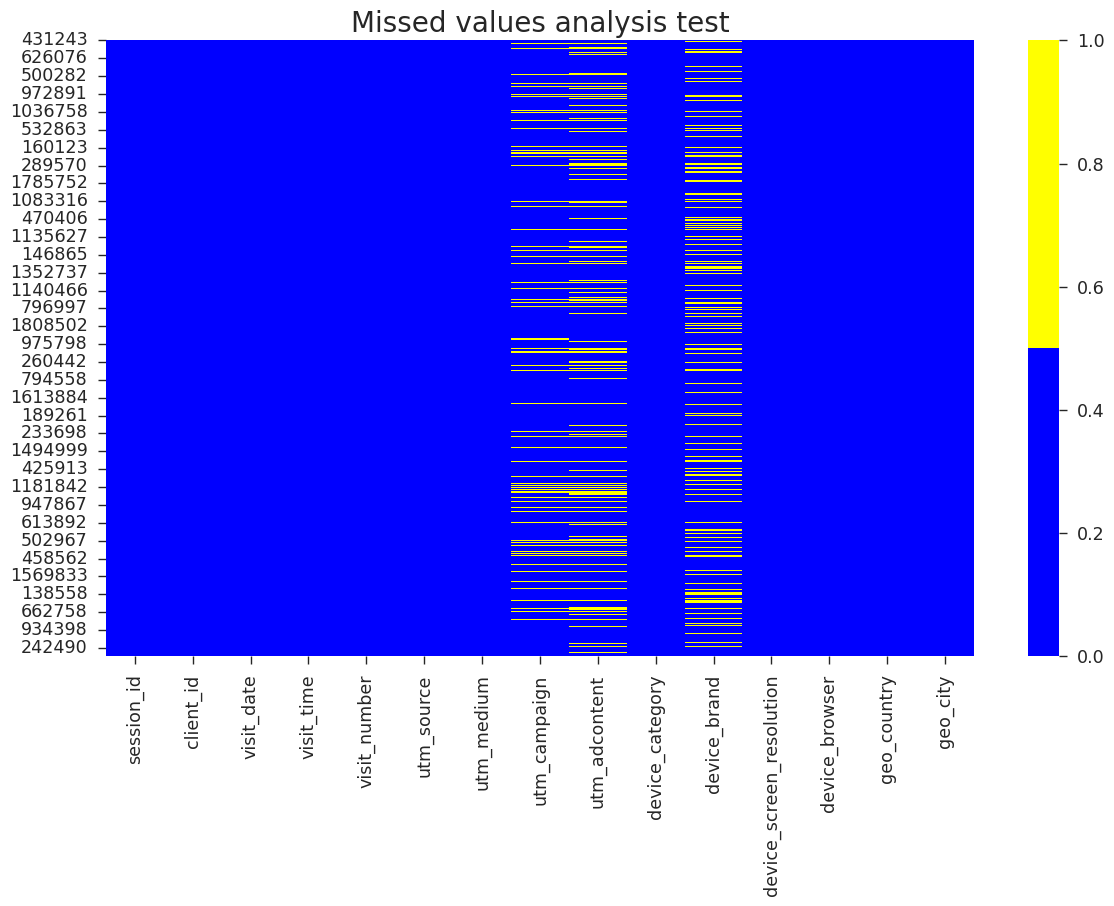

In [38]:
from jupyterthemes import jtplot
jtplot.style(context='notebook', ticks=True, grid=False)

plt.figure(figsize=(14, 8))
plt.title('Missed values analysis test', fontsize=20)
sns.heatmap(df_session2.sample(2000).isnull(), cmap=sns.color_palette(['blue', 'yellow']))
plt.show()

### Дополнение целевыми переменными в столбец target

В датасете df_session хранятся сессии пользователей.
Введем новый столбец target, где запишем целевые события, которые возьмем из event_action. 
Целевую переменную считаем положительной, если за сессию состоялось хотя бы одно из целевых событий. 
Для тех сессий в sessions, для которых не нашлось ни одного события в df_hits, целевую переменную заполняем значением 0.Только 7.68% всех сессий закончилось совершением целевого действия.

In [39]:
df_hits = pd.read_csv(path + 'df_hits_prepared_for_modelling.csv', low_memory=False)

In [40]:
all_targets = ['sub_car_claim_click', 
               'sub_car_claim_submit_click',
               'sub_open_dialog_click', 
               'sub_custom_question_submit_click',
               'sub_call_number_click', 
               'sub_callback_submit_click', 
               'sub_submit_success',
               'sub_car_request_submit_click']

# заполняет столбец df_ga_hits['target'] 'True', если df_ga_hits['event_action'] содержит целевую
df_hits['target'] = df_hits['event_action'].isin(all_targets)
# target группирует по id (session_id) и по столбцу 'target', то есть все одинаковые session_id собираются
target = df_hits.groupby('session_id')['target'].any() 
# добавляем к df_session target
df_session2 = df_session2.join(target, on='session_id') 


In [41]:
# добавляем к df_ столбцы, которые могут пригодиться при моделировании
temp=df_hits[['car_brand','car_model','visit_date_weekday', 'visit_date_month', 'session_id']]
df_session2 = df_session2.merge(temp, how='inner', on='session_id')
df_session2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12288163 entries, 0 to 12288162
Data columns (total 20 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   device_category           object
 10  device_brand              object
 11  device_screen_resolution  object
 12  device_browser            object
 13  geo_country               object
 14  geo_city                  object
 15  target                    object
 16  car_brand                 object
 17  car_model                 object
 18  visit_date_weekday        int64 
 19  visit_date_month          int64 
dtypes: int64(3), object(17)
memory usage: 1.9+ G

In [42]:
df_session2.shape

(12288163, 20)

In [43]:
del df_hits

In [44]:
def as_percent(x: float) -> str:
    """Используется для преобразования доли в процент (в виде строки)."""
    
    return f'{x:0.2%}'

print('Распределение целевой переменной:')
df_session2["target"].value_counts(dropna=False, normalize=True).apply(as_percent)

Распределение целевой переменной:


False    92.32%
True      7.68%
Name: target, dtype: object

In [45]:
# заполним Nan как False и все переведем в '0' и '1'
df_session2['target'] = df_session2['target'].fillna(False).astype(int)  
df_session2["target"].value_counts(dropna=False, normalize=True).apply(as_percent)
df_session2['target'].value_counts()

0    11344105
1      944058
Name: target, dtype: int64

In [46]:
# Функция определения процента целевых действий
def target_percentage(
    data: pd.DataFrame, 
    column: str, 
    index_name: str = '',
    only_target: bool = False, 
    sort: bool = True, 
    percent: bool = True 
) -> Union[pd.DataFrame, pd.Series]:
    """Возвращает в удобном виде процент целевых действий (`target`==1) 
    по значениям заданной колонки `column`."""

    # названия колонок
    count = 'Количество объектов'
    ratio = 'Доля от общего числа'
    target = 'Процент целевых действий'

    # разбиение по значениям
    groupby = data.groupby(column)
    
    # расчёт количества объектов и доли целевых действий
    result = pd.DataFrame(index=groupby.groups)
    result[count] = groupby[column].count()
    result[ratio] = result[count] / len(data)
    result[target] = groupby['target'].sum() / result[count]
    
    # форматирование выходной таблицы
    result.index.name = index_name or column
    if sort: result = result.sort_values(target, ascending=False)
    if percent: 
        result[target] = result[target].apply(as_percent)
        result[ratio] = result[ratio].apply(as_percent)
    
    # возвращение результатов
    if only_target: 
        return result[target].rename('target_percentage')
    return result

In [47]:
print('Процент целевых действий по дням недели:')
target_percentage(df_session2, 'visit_date_weekday', index_name='День недели')

Процент целевых действий по дням недели:


,Количество объектов,Доля от общего числа,Процент целевых действий
День недели,,,
0,2089895,17.01%,8.58%
2,1748123,14.23%,7.80%
1,2056354,16.73%,7.63%
5,1432022,11.65%,7.61%
3,1750785,14.25%,7.56%
6,1502271,12.23%,7.26%
4,1708713,13.91%,7.09%


In [48]:
# в целевой переменной есть пропуски
print(df_session2.isna().sum())

session_id                        0
client_id                         0
visit_date                        0
visit_time                        0
visit_number                      0
utm_source                      537
utm_medium                        0
utm_campaign                1915746
utm_adcontent               2393695
device_category                   0
device_brand                3249651
device_screen_resolution          0
device_browser                    0
geo_country                       0
geo_city                          0
target                            0
car_brand                         0
car_model                         0
visit_date_weekday                0
visit_date_month                  0
dtype: int64


### Session_id (ID визита) 
все значения в столбце уникальны - одно значение - одно посещение сайта
Пустых значений в колонке нет. 
Данная колонка может использоваться в качестве индекса в окончательном датасете.
тк все соединения сделаны ранее, данный столбец удаляем

In [49]:
df_session2 = df_session2.drop(['session_id'], axis=1)
df_session2.shape

(12288163, 19)

### Client_id (ID посетителя) 
все значения в столбце уникальны - одно значение - один посетитель, некоторые клиенты посещают сайт больше одного раза

клиент с № 1750498477.1629450062 - чаще всего посещал сайт. 462 раза
удаляем данный столбец удаляем

In [50]:
print('уникальные значения', df_session2['client_id'].describe())
print('уникальные значения', df_session2['client_id'].value_counts().head(5))
df_session2 = df_session2.drop(['client_id'], axis=1)
df_session2.shape

уникальные значения count                 12288163
unique                  722615
top       736859557.1619557452
freq                      4638
Name: client_id, dtype: object
уникальные значения 736859557.1619557452     4638
1750498477.1629450062    3448
1485840051.1622209619    3287
106350095.1635936693     2633
471358394.1635690930     2304
Name: client_id, dtype: int64


(12288163, 18)

### Visit_date (дата визита)

Пустых значений в колонке нет.
Диапазон представленных дат: с 19 мая 2021 по 31 декабря 2021. За изучаемый период 226 дней сайт посетили и совершили 50760 целевых действий.

В целом на графике количества посещений наблюдается небольшой восходящий тренд.

И ещё на графике очень заметен пик посещений в мае 2021, скорее всего это связано с запуском сервиса и проведенной в связи с этим рекламной кампанией, новостями о новом сервисе.

Больше сессий происходит и больше целевых действий совершается в начале недели.

Сама колонка visit_date участвовать в окончательном датасете не будет, но из неё можно получить признаки visit_date_weekday - день недели, visit_date_weekend - выходной, visit_date_day - день месяца

Text(0.5, 1.0, 'Количество сессий по дням')

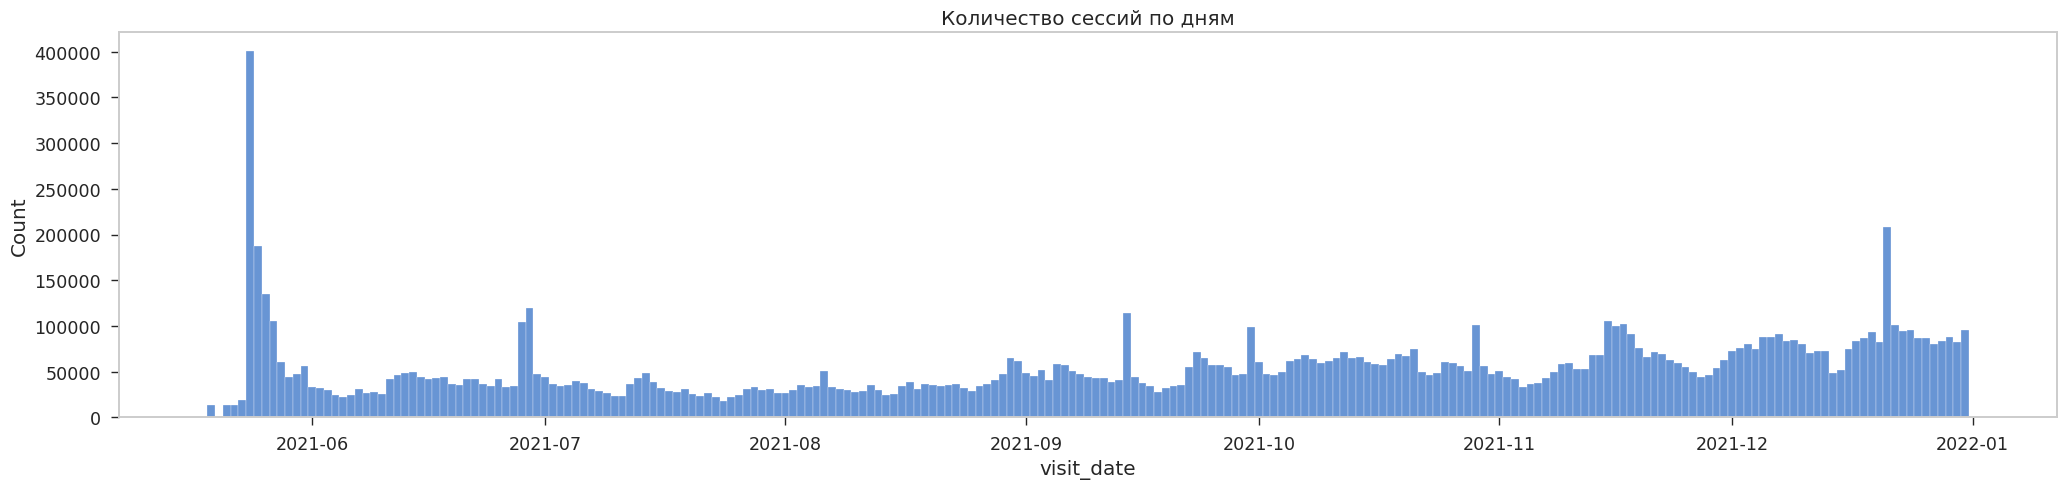

In [51]:
# переведем формат в дату
df_session2['visit_date'] = pd.to_datetime(df_session2.visit_date, utc=True)
df_session2['visit_date'].describe(datetime_is_numeric=True) 
plt.figure(figsize=(25, 5))
sns.histplot(df_session2, x='visit_date', discrete=True)
plt.title('Количество сессий по дням')

### Visit_date_weekday - новый признак
Для того, чтобы проанализировать количество посещений по дням, создадим новый признак - день недели 


In [52]:
df_session2['visit_date_weekday2'] = df_session2['visit_date'].dt.day_of_week


### Visit_date_weekend (время визита в выходной) - новый признак

In [53]:
df_session2['visit_date_weekend'] = df_session2['visit_date_weekday'] > 4 # присвоим "True" выходным (суббота и воскресенье) 5, 6 > 4
print('Распределение выходных дней:')
target_percentage(df_session2, 'visit_date_weekend', index_name='Выходной')

Распределение выходных дней:


,Количество объектов,Доля от общего числа,Процент целевых действий
Выходной,,,
False,9353870,76.12%,7.76%
True,2934293,23.88%,7.43%


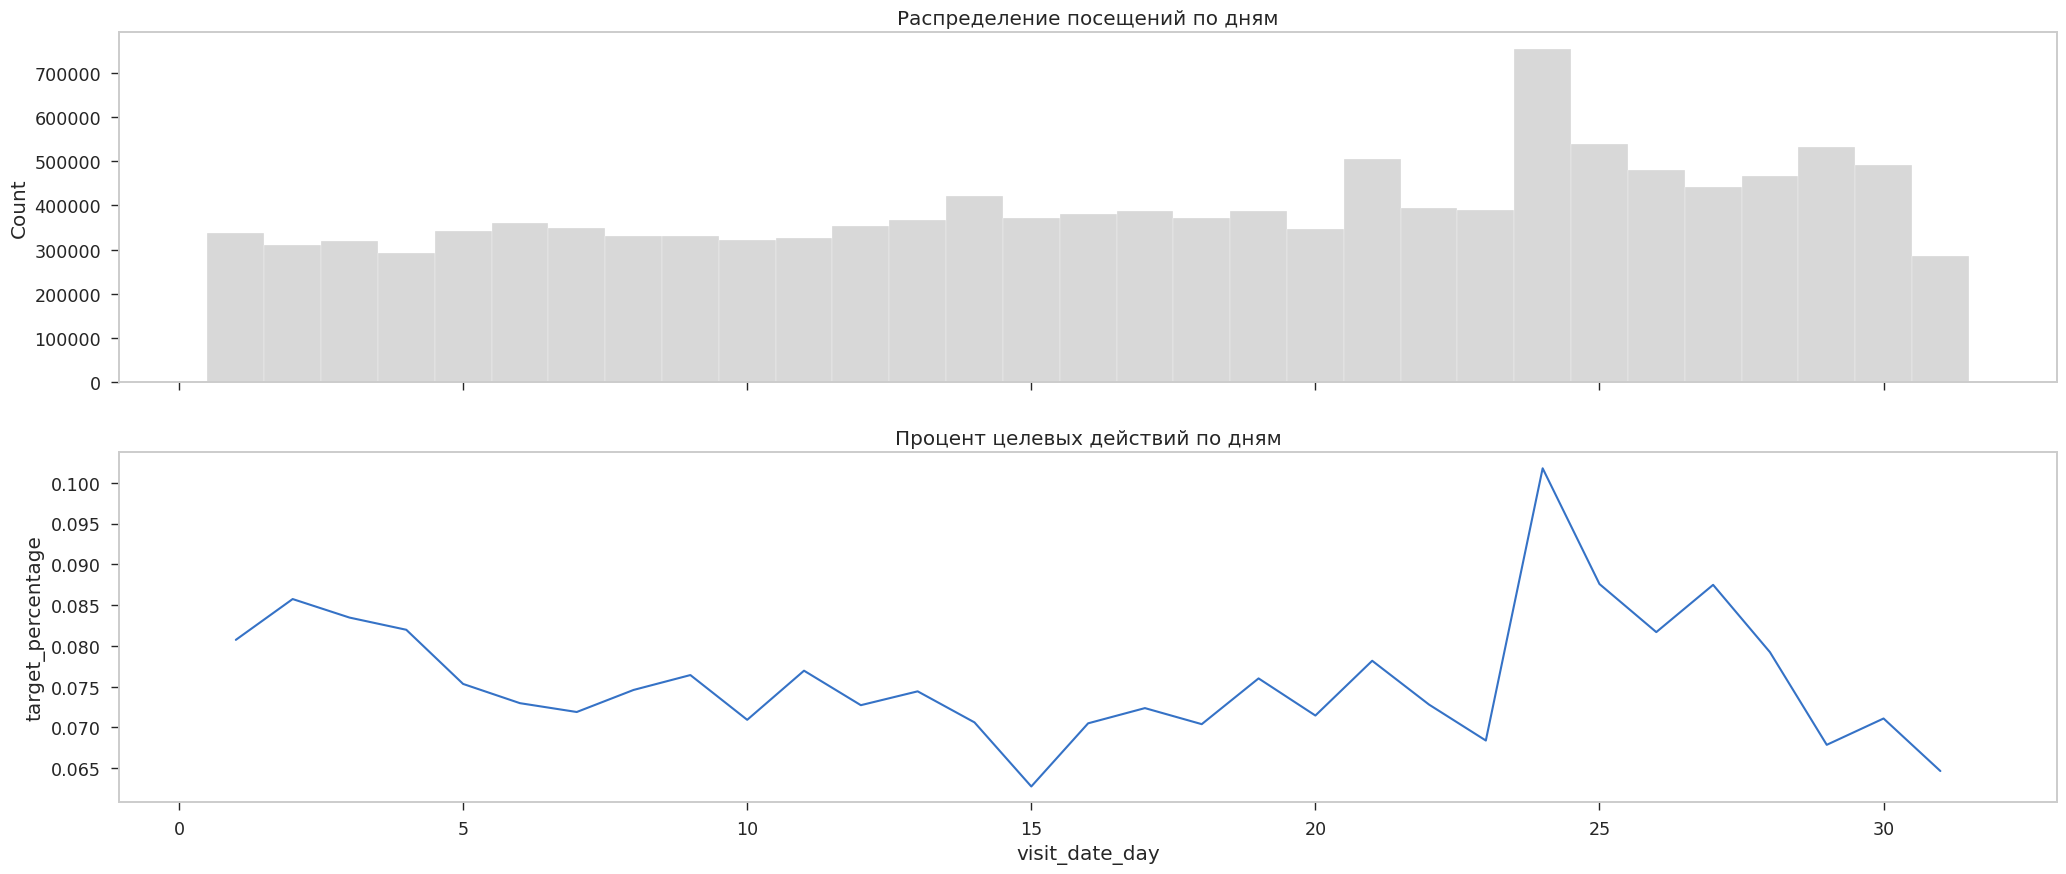

In [54]:
df_session2['visit_date_day'] = df_session2['visit_date'].dt.day # заполняет столбец днем месяца из даты
_, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(25, 10))

ax1.set_title('Распределение посещений по дням')
sns.histplot(data=df_session2, x='visit_date_day', discrete=True, ax=ax1)

target_by_day = target_percentage(df_session2, 'visit_date_day', 
                                  percent=False, only_target=True)
ax2.set_title('Процент целевых действий по дням')
sns.lineplot(data=target_by_day, ax=ax2);

In [55]:
df_session2

,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,...,geo_country,geo_city,target,car_brand,car_model,visit_date_weekday,visit_date_month,visit_date_weekday2,visit_date_weekend,visit_date_day
0,2021-12-28 00:00:00+00:00,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,...,Russia,Krasnoyarsk,0,skoda,rapid,1,12,1,False,28
1,2021-12-28 00:00:00+00:00,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,...,Russia,Krasnoyarsk,0,skoda,rapid,1,12,1,False,28
2,2021-12-28 00:00:00+00:00,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,...,Russia,Krasnoyarsk,0,skoda,rapid,1,12,1,False,28
3,2021-12-28 00:00:00+00:00,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,...,Russia,Krasnoyarsk,0,skoda,rapid,1,12,1,False,28
4,2021-12-28 00:00:00+00:00,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,...,Russia,Krasnoyarsk,0,skoda,rapid,1,12,1,False,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12288158,2021-12-31 00:00:00+00:00,19:39:02,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,NaN,1366x768,...,Russia,Moscow,0,bmw,3-serii,4,12,4,False,31
12288159,2021-12-31 00:00:00+00:00,19:39:02,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,NaN,1366x768,...,Russia,Moscow,0,bmw,3-serii,4,12,4,False,31
12288160,2021-12-31 00:00:00+00:00,19:39:02,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,NaN,1366x768,...,Russia,Moscow,0,mercedes-benz,e-klasse,4,12,4,False,31
12288161,2021-12-31 00:00:00+00:00,19:39:02,1,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,desktop,NaN,1366x768,...,Russia,Moscow,0,bmw,3-serii,4,12,4,False,31


In [56]:
# удалим ненужные столбцы
df_session2 = df_session2.drop(['visit_date', 'visit_date_weekday2'], axis=1)
df_session2.shape

(12288163, 19)

### Visit_time (время визита)

Пустых значений в колонке нет.
Временные значения представлены от 00:00:00 до 23:59:59, то есть покрывают весь день.
Пик посещений сайта наблюдается в 14:00, то есть в середине дня.

Больший процент сессий закрывается целевым действием в середине дня (11:00-16:00), а меньший - ночью (2:00-6:00).
Большинство сессий происходит на нулевой минуте каждого часа, причём с большим процентом целевых действий.
Это больше похоже на алгоритмические действия, чем на реальные посещения сайта пользователем.

Сам по себе признак visit_time неудобен в использовании, но из него можно получить полезные признаки, 
например, visit_hour - час визита пользователя, visit_minute - минута визита, visit_time_night - была ли ночь во время визита пользователя.

In [57]:
# переведем формат в дату

df_session2['visit_time'] = pd.to_datetime(df_session2.visit_time, utc=True)
df_session2['visit_time'].describe(datetime_is_numeric=True) 

count                               12288163
mean     2023-04-26 13:58:53.074624256+00:00
min                2023-04-26 00:00:00+00:00
25%                2023-04-26 10:00:00+00:00
50%                2023-04-26 14:32:24+00:00
75%                2023-04-26 19:00:00+00:00
max                2023-04-26 23:59:56+00:00
Name: visit_time, dtype: object

### Visit_time_hour - количество посещений по часам (новый признак)  

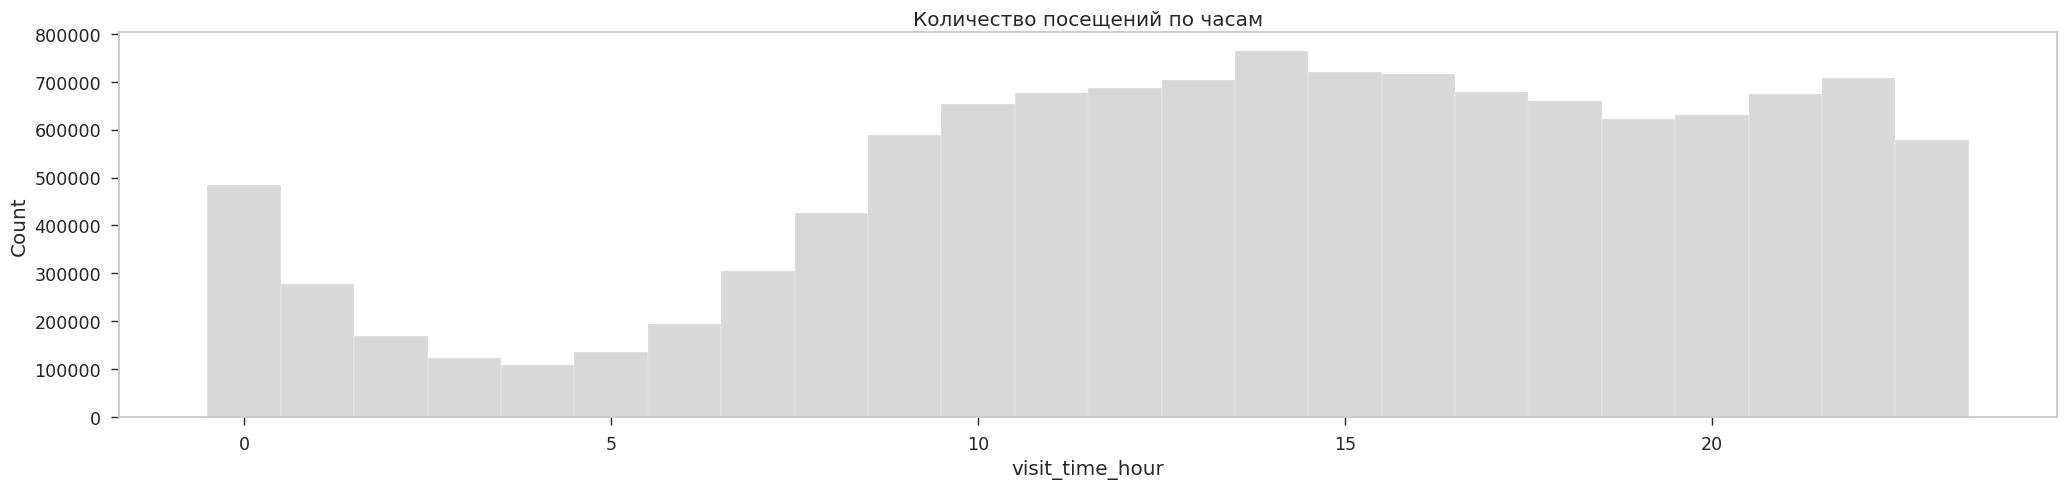

In [58]:
df_session2['visit_time_hour'] = df_session2['visit_time'].dt.hour
plt.figure(figsize=(25, 5))
sns.histplot(data=df_session2, x='visit_time_hour', discrete=True)
plt.title('Количество посещений по часам');

### Visit_time_night- кол-во посещений в ночное время (новый признак)



In [59]:
df_session2['visit_time_night'] = df_session2['visit_time_hour'] < 9
print('Распределение целевых действий ночью и днём:')
target_percentage(df_session2, 'visit_time_night', index_name='Ночное время')

Распределение целевых действий ночью и днём:


,Количество объектов,Доля от общего числа,Процент целевых действий
Ночное время,,,
True,2230480,18.15%,7.68%
False,10057683,81.85%,7.68%


In [61]:
# удалим ненужные столбцы
df_session2 = df_session2.drop(['visit_time'], axis=1)
df_session2.shape

(12288163, 20)

### Visit_number (порядковый номер визита клиента)

В колонке нет пустых значений. Для каждого посетителя по его client_id все его посещения фиксируются в visit_number. Большинство, а именно, 74% всех посещений составляет всего одно посещение, после которого клиент больше не заходит на сайт. Дальше на втором месте стоят клиенты, которые посетили 
сайт всего 2 раза, что составляет почти 13% от всего количества посещений.
Номер посещения колеблется от 1 до 564 посещений сайта. Большинство пользователей ограничиваются одним-двумя посещениями. Можно было бы подумать, что все посещения больше - 4 это выбросы, но, оказывается, что, несмотря,
что 74% составляют 1-е посещение и 12.67% составляют 2-е посещения, доля целевых действий в этих параметрах составляют всего 2.35% и 3.23% соответственно. Начиная с 4-го посещения доля целевых посещений в этом 
сегменте уже составляет свыше 4%.

Похоже, что чем чаще пользователь заходит на сайт, тем выше вероятность, что он совершит целевое действие.
Вероятно, первый раз пользователи заходят на сайт, чтобы познакомиться с предложением, а если их оно заинтересует, то они вернутся ещё раз.

In [62]:
df_session2['visit_number'].describe()
df_session2['visit_number'].value_counts()

1      8855512
2      1710674
3       535769
4       320717
5       165571
        ...   
344          2
322          2
428          2
307          2
541          1
Name: visit_number, Length: 432, dtype: int64

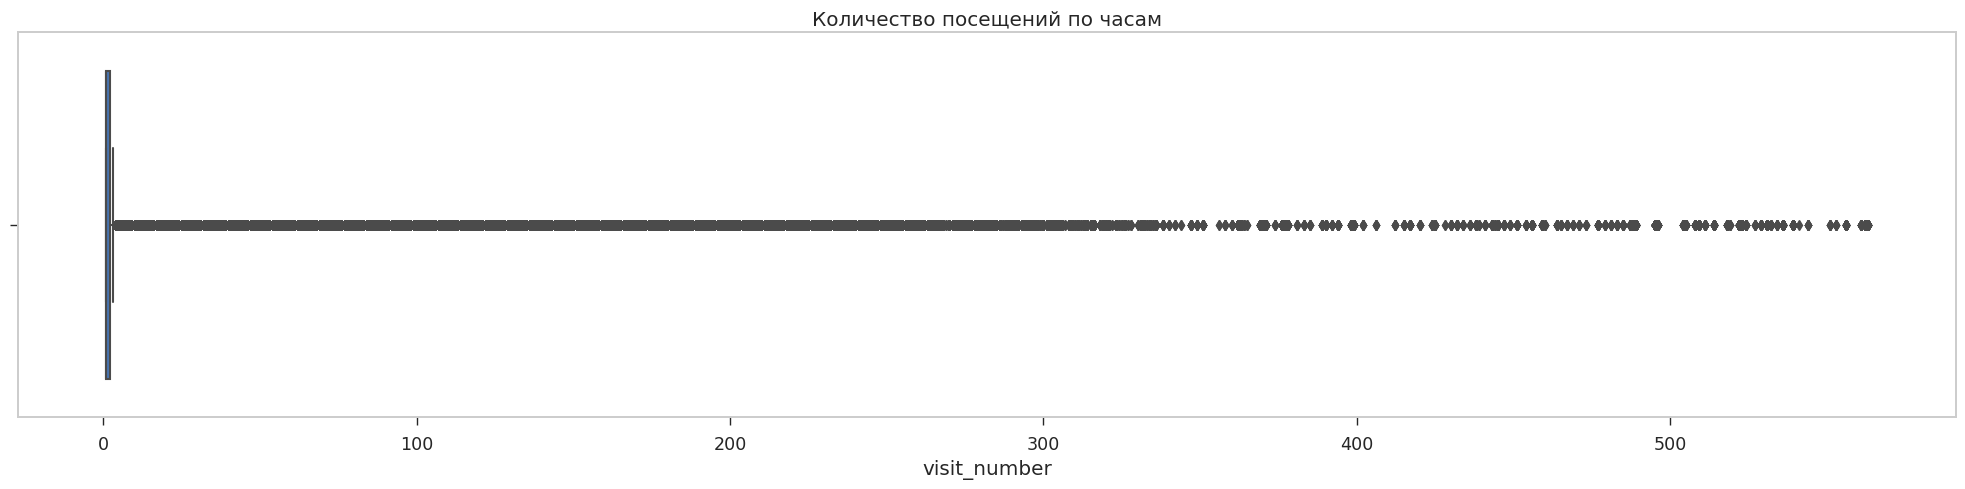

In [63]:
plt.figure(figsize=(25, 5))
sns.boxplot(data=df_session2, x='visit_number')
plt.title('Количество посещений по часам');

### Utm_source - канал привлечения
Пропусков в колонке не много - 97.

Уникальных значений много (293) и вряд ли они несут много полезной информации, можно в окончательный 
датасет взять только самые частые значения.



In [64]:
df_session2.utm_source.value_counts(dropna=False).head(3)
df_session2.utm_source = df_session2.utm_source.fillna('ZpYIoDJMcFzVoPFsHGJL')

### Utm_medium - тип привлечения


Уникальных значений 221.

Множество значений появляется в датасете слишком малое количество раз

banner      552272
cpc         434794
(none)      300575
cpm         242083

In [65]:
df_session2.utm_medium.value_counts(dropna=False).head(5)

banner      3754805
cpc         2683580
(none)      2658527
referral    1562637
organic      535193
Name: utm_medium, dtype: int64

In [66]:
#заполним значения none значениями частыми  banner
df_session2.loc[df_session2['utm_medium'] == '(none)', 'utm_medium'] = df_session2['utm_medium'].apply(lambda x: 'banner')

### Utm_campaign - рекламная кампания
12% значений в колонке пропущено. заполним частым значением LTuZkdKfxRGVceoWkVyg

In [67]:
df_session2.utm_campaign.value_counts(dropna=False).head(5)
df_session2.utm_campaign = df_session2.utm_source.fillna('LTuZkdKfxRGVceoWkVyg')

### utm_adcontent 
12% значений в колонке пропущено. заполним частым значением JNHcPlZPxEMWDnRiyoBf

In [68]:
df_session2.utm_adcontent.value_counts(dropna=False).head(5)
df_session2.utm_adcontent = df_session2.utm_source.fillna('JNHcPlZPxEMWDnRiyoBf')

### Device_category - тип устройства


In [69]:
print(f'Пропущенных значений в "device_category": {df_session2.device_category.isna().sum()}')
n_unique = df_session2.device_category.nunique()
print(f'Количество уникальных значений в `utm_medium`: {n_unique}')
print('Процент целевых действий по категориям устройств: ')
target_percentage(df_session2, 'device_category', index_name='Тип устройства')

Пропущенных значений в "device_category": 0
Количество уникальных значений в `utm_medium`: 3
Процент целевых действий по категориям устройств: 


,Количество объектов,Доля от общего числа,Процент целевых действий
Тип устройства,,,
mobile,8925937,72.64%,7.79%
desktop,3249437,26.44%,7.43%
tablet,112789,0.92%,6.73%


### Device_brand - марка устройства


In [70]:
df_session2.device_brand.value_counts(dropna=False).head(5)
df_session2.device_brand = df_session2.device_brand.fillna('Apple')

In [71]:
print(f'Пропущенных значений в "device_brand": {df_session2.device_brand.isna().sum()}')
n_unique = df_session2.device_brand.nunique()
print(f'Количество уникальных значений в `utm_medium`: {n_unique}')
print('Процент целевых действий по категориям устройств: ')
target_percentage(df_session2, 'device_brand', index_name='Тип устройства')

Пропущенных значений в "device_brand": 0
Количество уникальных значений в `utm_medium`: 146
Процент целевых действий по категориям устройств: 


,Количество объектов,Доля от общего числа,Процент целевых действий
Тип устройства,,,
Motive,9,0.00%,100.00%
Condor,123,0.00%,72.36%
Razer,46,0.00%,32.61%
AGM,194,0.00%,32.47%
Haier,227,0.00%,18.94%
...,...,...,...
Iris,28,0.00%,0.00%
Inoi,309,0.00%,0.00%
InnJoo,15,0.00%,0.00%


In [72]:
df_session2.isna().sum()

visit_number                0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
device_category             0
device_brand                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
target                      0
car_brand                   0
car_model                   0
visit_date_weekday          0
visit_date_month            0
visit_date_weekend          0
visit_date_day              0
visit_time_hour             0
visit_time_night            0
dtype: int64

### Device_screen_resolution - разрешение экрана


In [73]:
split = df_session2['device_screen_resolution'].str.split('x', expand=True)
# создадим столбцы с шириной и длиной, куда занесем значения
df_session2[['device_screen_width', 'device_screen_height']] = split
df_session2[['device_screen_width', 'device_screen_height']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12288163 entries, 0 to 12288162
Data columns (total 2 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   device_screen_width   object
 1   device_screen_height  object
dtypes: object(2)
memory usage: 539.3+ MB


In [74]:
df_session2[['device_screen_width', 'device_screen_height']].head(4)

,device_screen_width,device_screen_height
0,360,720
1,360,720
2,360,720
3,360,720


In [75]:
df_session2.isna().sum()

visit_number                0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
device_category             0
device_brand                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
target                      0
car_brand                   0
car_model                   0
visit_date_weekday          0
visit_date_month            0
visit_date_weekend          0
visit_date_day              0
visit_time_hour             0
visit_time_night            0
device_screen_width         0
device_screen_height        0
dtype: int64

In [76]:

df_session2['device_screen_width'] = pd.to_numeric(df_session2['device_screen_width'], errors='coerce')
df_session2['device_screen_height'] = pd.to_numeric(df_session2['device_screen_height'], errors='coerce')
df_session2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12288163 entries, 0 to 12288162
Data columns (total 22 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   visit_number              int64 
 1   utm_source                object
 2   utm_medium                object
 3   utm_campaign              object
 4   utm_adcontent             object
 5   device_category           object
 6   device_brand              object
 7   device_screen_resolution  object
 8   device_browser            object
 9   geo_country               object
 10  geo_city                  object
 11  target                    int64 
 12  car_brand                 object
 13  car_model                 object
 14  visit_date_weekday        int64 
 15  visit_date_month          int64 
 16  visit_date_weekend        bool  
 17  visit_date_day            int64 
 18  visit_time_hour           int64 
 19  visit_time_night          bool  
 20  device_screen_width       int64 
 21  device

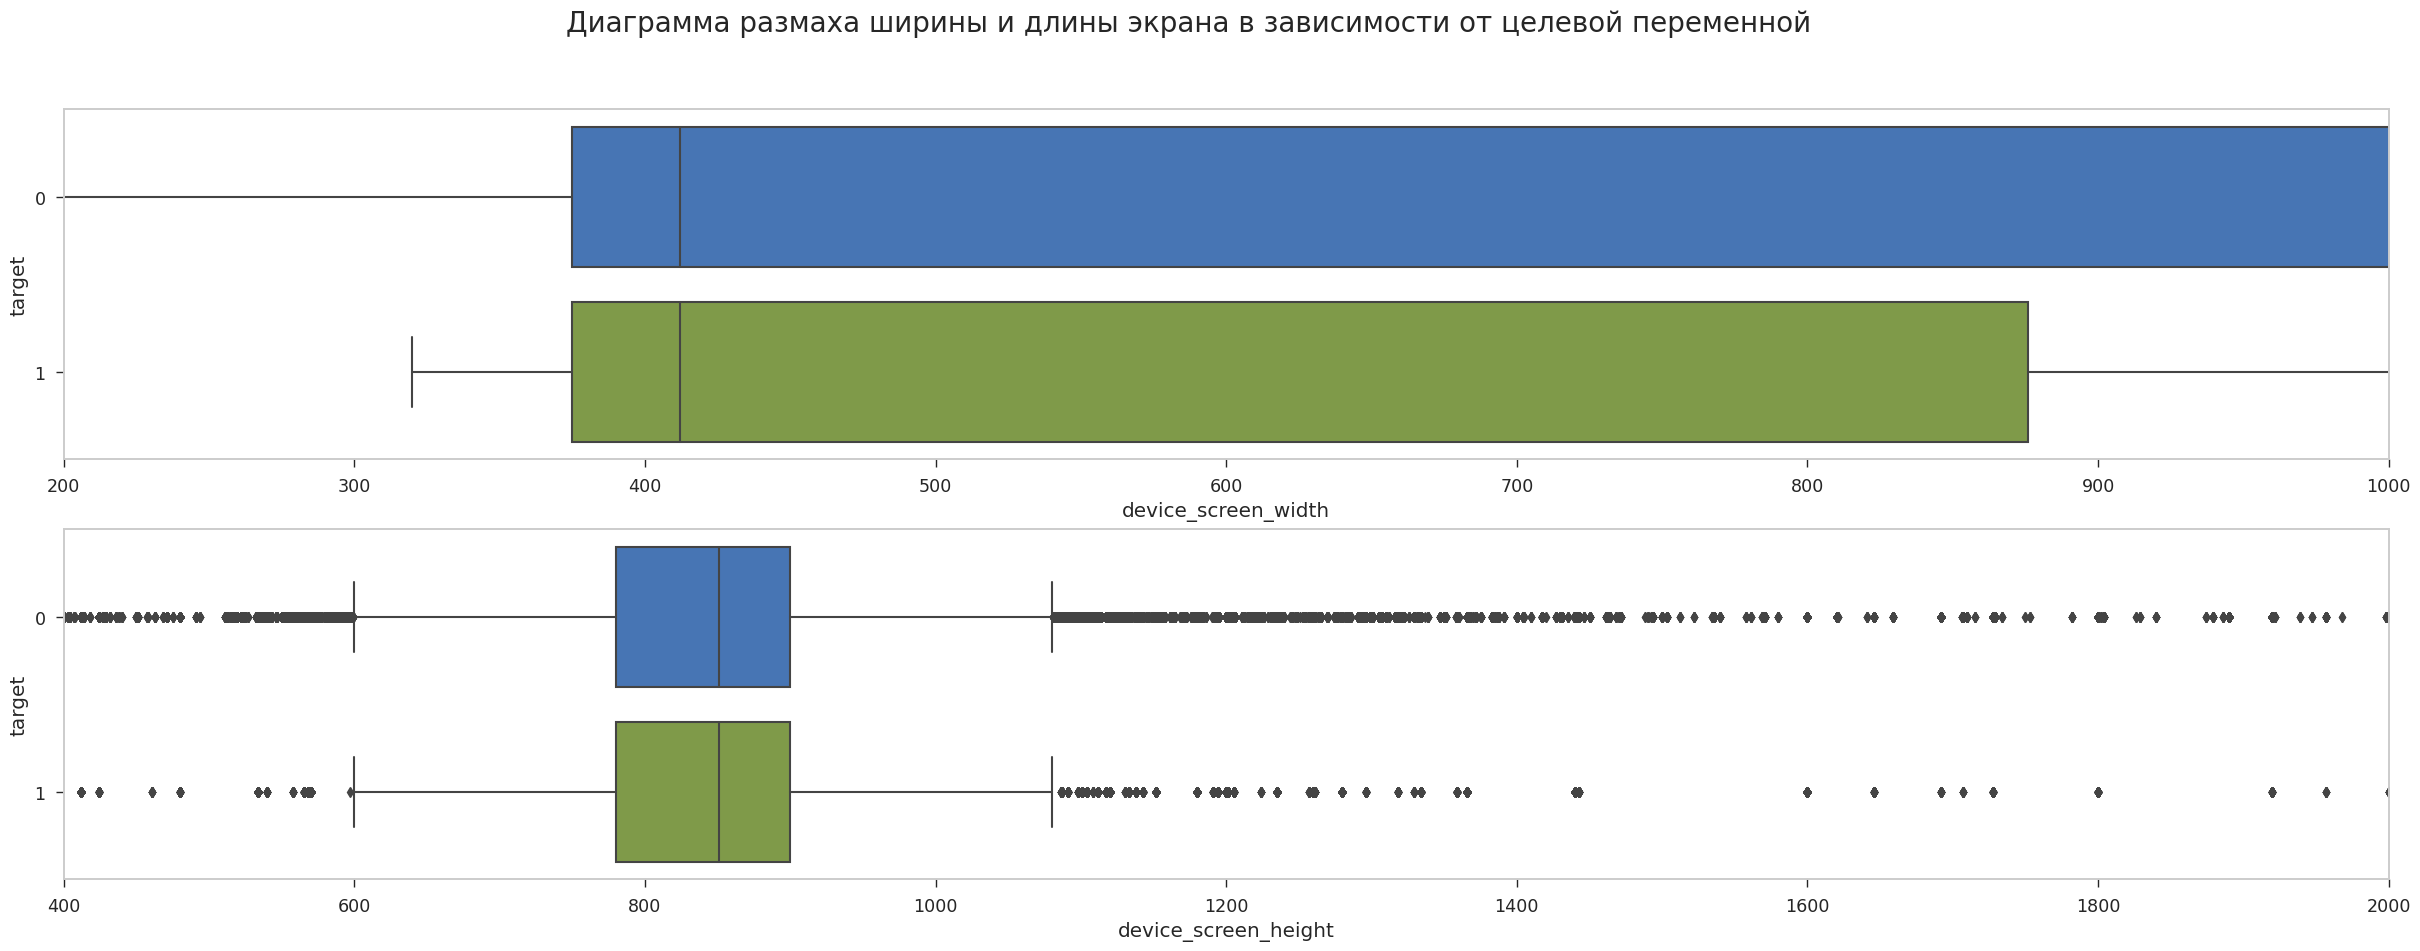

In [77]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30, 10))

sns.boxplot(data=df_session2, x='device_screen_width', 
            y='target', ax=ax1, orient='h')
sns.boxplot(data=df_session2, x='device_screen_height', 
            y='target', ax=ax2, orient='h')

# ограничим показ выбросов
ax1.set_xlim(200, 1000)
ax2.set_xlim(400, 2000)

fig.suptitle(f'Диаграмма размаха ширины и длины экрана '
             f'в зависимости от целевой переменной', fontsize='20')
plt.show()

In [78]:
#создадим доп признаки
df_session2['device_screen_area'] = df_session2['device_screen_width'] * df_session2['device_screen_height']
df_session2['device_screen_ratio'] = df_session2['device_screen_width'] / df_session2['device_screen_height']

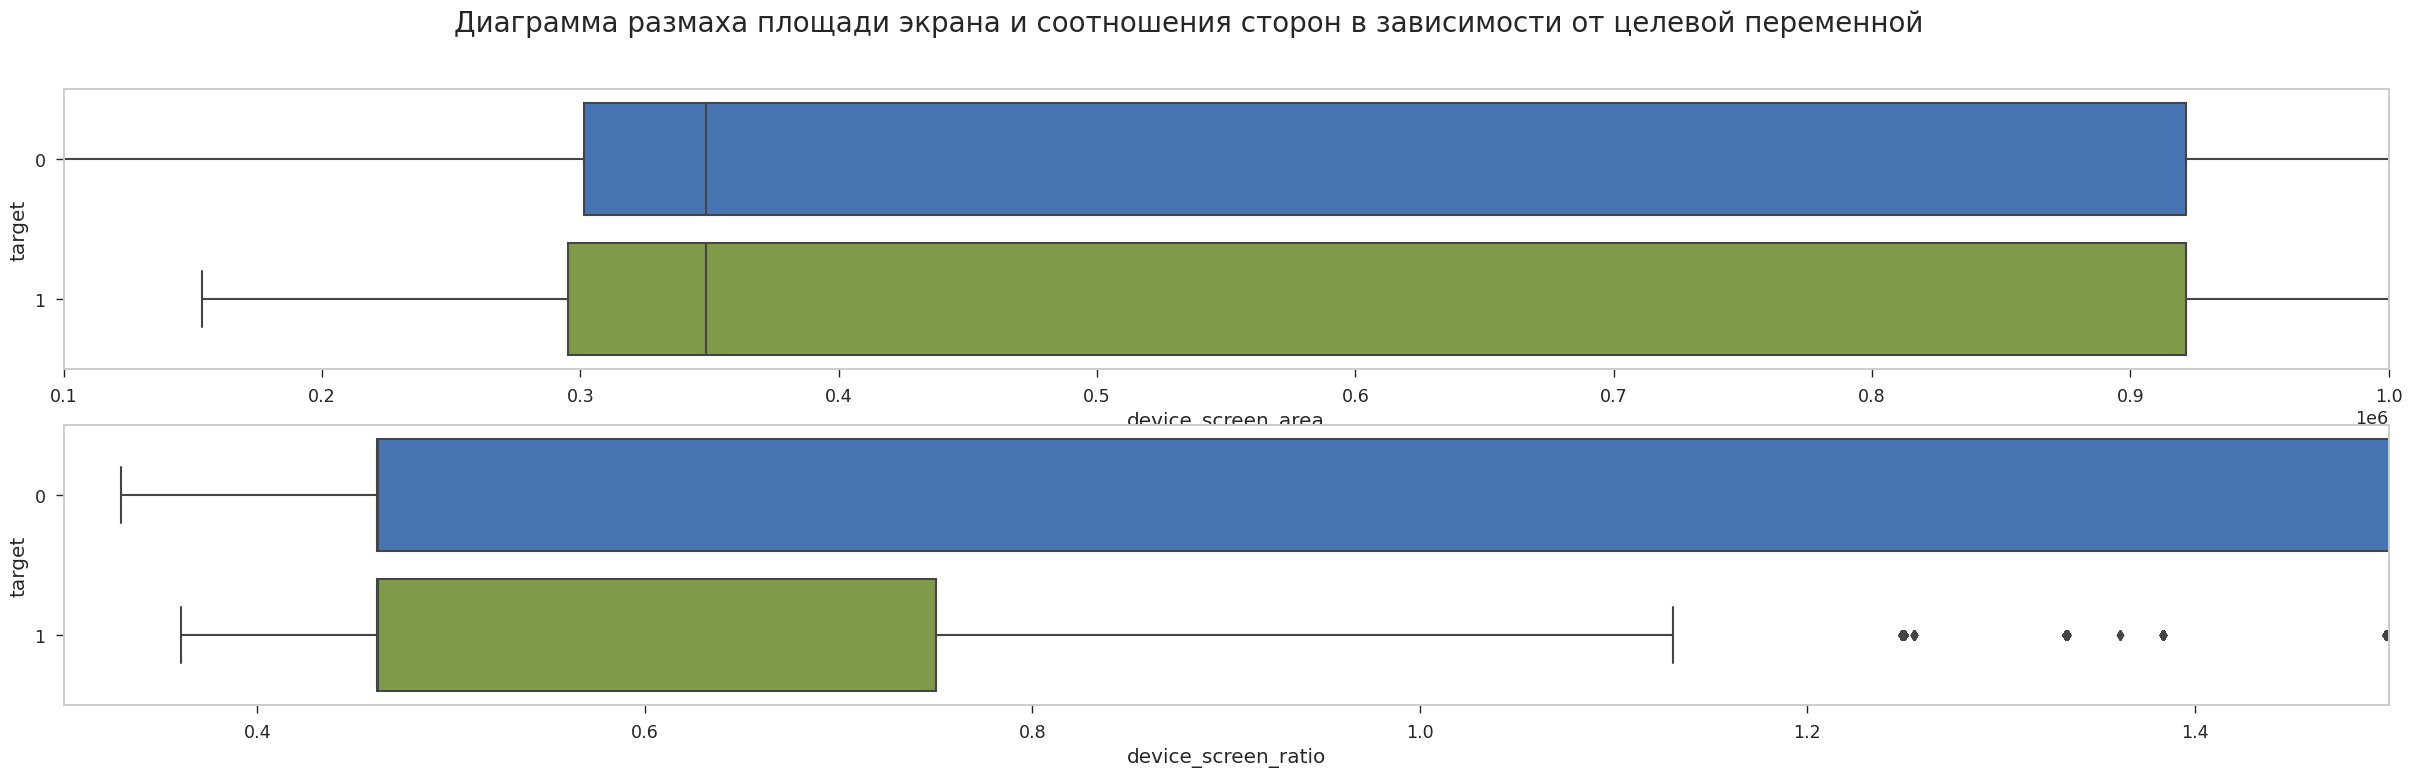

In [79]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(30, 8))

sns.boxplot(data=df_session2, x='device_screen_area', 
            y='target', ax=ax1, orient='h')
sns.boxplot(data=df_session2, x='device_screen_ratio', 
            y='target', ax=ax2, orient='h')

# ограничим показ выбросов
ax1.set_xlim(100_000, 1_000_000)
ax2.set_xlim(0.3, 1.5)

fig.suptitle(f'Диаграмма размаха площади экрана и соотношения сторон '
             f'в зависимости от целевой переменной', fontsize='20')
plt.show()

### Geo_country -страна

In [80]:
df_session2['geo_country'].value_counts(dropna=False).head(15)

Russia            11958333
Ukraine              59369
United States        26856
Belarus              23300
Germany              21084
Turkey               15318
Kazakhstan           12455
Netherlands          12293
United Kingdom       11525
(not set)             9018
Georgia               7691
Sweden                7519
Cyprus                6619
France                6236
Kyrgyzstan            6178
Name: geo_country, dtype: int64

In [81]:
df_session2['geo_country_is_russia'] = df_session2['geo_country'] == 'Russia'

print('Процент целевых действий в России:')
target_percentage(df_session2, 'geo_country_is_russia', index_name='Россия')

Процент целевых действий в России:


,Количество объектов,Доля от общего числа,Процент целевых действий
Россия,,,
True,11958333,97.32%,7.70%
False,329830,2.68%,7.02%


### geo_city - город

In [82]:
big_cities = ['Moscow', 'Saint Petersburg', 'Novosibirsk', 'Yekaterinburg', 
              'Kazan', 'Nizhny Novgorod', 'Chelyabinsk', 'Samara', 'Omsk', 
              'Rostov-on-Don', 'Ufa', 'Krasnoyarsk', 'Voronezh', 'Perm', 
              'Volgograd', 'Krasnodar', 'Saratov', 'Tyumen']


df_session2['geo_city_is_big'] = df_session2['geo_city'].isin(big_cities)


In [83]:
print('Процент целевых действий для больших городов:')
target_percentage(df_session2, 'geo_city_is_big', index_name='Большой город')

Процент целевых действий для больших городов:


,Количество объектов,Доля от общего числа,Процент целевых действий
Большой город,,,
True,9148699,74.45%,7.77%
False,3139464,25.55%,7.44%


### Построим признак - расстояние от Москвы geo_city_distance_from_moscow. Расстояния получены с помощью библиотеки geopy . Расстояния есть только для российских городов, для остальных расстояние -1.

In [84]:
distances_from_moscow = {
    'zlatoust': 1391.263586320666,
    'moscow': 0.0,
    'krasnoyarsk': 3336.039749777034,
    'saint petersburg': 636.1695135872066,
    'sochi': 1361.357154793485,
    'yaroslavl': 251.13992274208584,
    'mytishchi': 19.15256793901058,
    'novorossiysk': 1226.5566120134847,
    'balashikha': 22.57464380465976,
    'pushkino': 32.29150343512499,
    'vladivostok': 6434.301687239597,
    'alexandrov': 99.03461742181614,
    'astrakhan': 1272.5934764474214,
    'reutov': 15.066736856880723,
    'kazan': 721.4395898259049,
    'ulyanovsk': 704.8643503547661,
    'tula': 173.37597779851754,
    'yekaterinburg': 1421.8971980595,
    'rostov-on-don': 959.8830610946284,
    'samara': 856.8315253096929,
    'domodedovo': 36.1846810301295,
    'yoshkar-ola': 645.0905459206801,
    'chelyabinsk': 1498.8592485500628,
    'krasnogorsk': 19.128893627152596,
    'krasnodar': 1114.8111085097096,
    'lipetsk': 353.93468708196895,
    'nakhabino': 29.34753329618301,
    'kyzyl': 3669.160067257817,
    'ryazan': 184.0749867936237,
    'tyumen': 1716.8034849522674,
    'omsk': 2243.230614478407,
    'nizhny novgorod': 403.1271008941555,
    'irkutsk': 3997.3240242086913,
    'mezhdurechensk': 3186.977397404048,
    'stupino': 100.50298403934347,
    'serpukhov': 93.79639415363022,
    'saratov': 727.5243756615845,
    'grozny': 1498.6390016944135,
    'orenburg': 1230.997301228693,
    'surgut': 2143.5097426260527,
    'volgograd': 913.40653000604,
    'engels': 734.1820123219143,
    'fryazino': 35.68825436908673,
    'naberezhnye chelny': 926.5455187130812,
    'khabarovsk': 5955.703005291212,
    'ufa': 1168.153047105715,
    'novosibirsk': 2820.763592183317,
    'kirov': 793.5857281587636,
    'kotelniki': 18.556201509278427,
    'kaluga': 162.98501946171325,
    'vyborg': 758.2625638645857,
    'barnaul': 2943.257935404941,
    'tambov': 419.072146029825,
    'tver': 162.03184502252185,
    'korolyov': 23.240966914958825,
    'kostroma': 302.3271334606748,
    'zheleznodorozhny': 1051.3212963591216,
    'dolgoprudny': 21.451753870279653,
    'kursk': 456.3676328552856,
    'pyatigorsk': 1359.1346795165907,
    'khimki': 19.27787504978214,
    'dubna': 113.336078534706,
    'izhevsk': 970.8632565557036,
    'chita': 4752.38859817778,
    'cherkessk': 1319.672066231367,
    'blagoveshchensk': 5630.258195023883,
    'bryansk': 349.6394555186336,
    'voronezh': 467.015180857099,
    'kolomna': 103.33805649619023,
    'nalchik': 1430.5028996363571,
    'obninsk': 96.82910844583522,
    'belgorod': 577.7869858749181,
    'perm': 1170.262093684163,
    'severodvinsk': 989.3463180226084,
    'gatchina': 616.369780994091,
    'syktyvkar': 1007.3633668496318,
    'naro-fominsk': 68.51450800685191,
    'protvino': 101.15152863427636,
    'kamensk-uralsky': 1506.829417564834,
    'zhukovskiy': 600.4219593564324,
    'tomsk': 2655.7361007309364,
    'stavropol': 1278.9876969538484,
    'ivanteyevka': 31.051927448382365,
    'yegoryevsk': 98.37617987397816,
    'magnitogorsk': 1399.4447582737268,
    'vidnoye': 22.273670822552017,
    'abakan': 3386.4037130516103,
    'kraskovo': 24.96235703886392,
    'safonovo': 286.2924673657379,
    'shlisselburg': 608.2272247268463,
    'cherepovets': 376.65445395984784,
    'arkhangelsk': 992.6837722348444,
    'lyubertsy': 19.131687885364908,
    'vologda': 578.1169534315311,
    'petrozavodsk': 697.9721736505935,
    'oryol': 325.58358692835327,
    'odintsovo': 23.396555594006895,
    'voskresensk': 82.36561436203819,
    'almetyevsk': 934.756507490178,
    'veliky novgorod': 492.2434986334845,
    'kovrov': 240.34824684527445,
    'ramenskoye': 43.322630130479546,
    'berezniki': 1212.7987454012757,
    'shchyolkovo': 30.14037479489325,
    'novocheboksarsk': 617.6614496689281,
    'maykop': 1252.0417154745587,
    'nefteyugansk': 2101.016020281276,
    'tomilino': 587.5370629562508,
    'kaliningrad': 1091.7810203900708,
    'vladimir': 179.35415952478112,
    'velikiye luki': 446.4897914407206,
    'nakhodka': 6512.826751067336,
    'nizhnevartovsk': 2316.101568624056,
    'nevinnomyssk': 1274.9648982402225,
    'klin': 85.25341211585662,
    'uchaly': 1395.0694573085807,
    'novy urengoy': 2357.070596933191,
    'smolensk': 370.11957641629294,
    'dedovsk': 33.44282124708212,
    'sergiyev posad': 70.71201081392101,
    'vsevolozhsk': 629.8608377734972,
    'dmitrov': 66.48470950822428,
    'cheboksary': 602.6003537044186,
    'podolsk': 35.868186236649,
    'pervouralsk': 1380.892115200903,
    'anapa': 1207.7697317191653,
    'lytkarino': 26.171266900562145,
    'kopeysk': 1513.6217762611632,
    'tosno': 582.7586696635991,
    'norilsk': 2890.251515258955,
    'tolyatti': 799.8381096242144,
    'temryuk': 1165.3624515813908,
    'ussuriysk': 6381.347211888504,
    'istra': 50.88951924026617,
    'murmansk': 1491.035365952789,
    'ivanovo': 249.58733461631263,
    'verkhnyaya pyshma': 1418.646108882692,
    'maloyaroslavets': 110.21255938028736,
    'tikhvin': 496.9134080491585,
    'neryungri': 5028.977481470272,
    'kurgan': 1630.4830408964883,
    'novomoskovsk': 198.39912622251103,
    'kemerovo': 2996.19975700017,
    'volokolamsk': 108.56175176242488,
    'elektrostal': 51.84872232603937,
    'essentuki': 1354.1058476615915,
    'kislovodsk': 1365.9041690419383,
    'malakhovka': 26.99082254199157,
    'orekhovo-zuyevo': 85.6729405699771,
    'angarsk': 4178.283677448494,
    'chekhov': 68.44709881944979,
    'severomorsk': 1499.3047699096576,
    'leninsk-kuznetskiy': 3024.4663354351296,
    'satka': 1353.5254445419057,
    'dzerzhinsk': 368.59794417334047,
    'хомутово': 6668.791623791499,
    'penza': 556.0305682853448,
    'biysk': 3068.7132170237933,
    'novokuznetsk': 3127.6022996940287,
    'lobnya': 30.440525152635374,
    'sterlitamak': 1201.8214869231806,
    'naryan-mar': 1546.3123404691437,
    'kamyshin': 819.0343184384951,
    'artyom': 6430.381425066174,
    'yurga': 2914.0593434459674,
    'asbest': 1471.9556267379069,
    'sertolovo': 656.4737697387209,
    'staraya kupavna': 35.69475828769861,
    'volzhskiy': 915.5424228748903,
    'yuzhno-sakhalinsk': 6662.822265097304,
    'dzerzhinsky': 19.755817456584587,
    'krasnoznamensk': 40.16986859789947,
    'ulan-ude': 4432.539381037524,
    'zarechnyy': 606.0887567751221,
    'kostomuksha': 1057.376319264544,
    'povarovo': 50.52734489960697,
    'meleuz': 1226.2104294516412,
    'nazran': 1483.2725769944918,
    'klimovsk': 42.08840658931683,
    'stary oskol': 495.74079214243545,
    'vorkuta': 1891.6302759858595,
    'poltavskaya': 1155.8248883948718,
    'lukhovitsy': 125.0361461564636,
    'beloozyorskiy': 61.073850334859074,
    'elektrougli': 38.19286528690888,
    'chebarkul': 1438.8690266914327,
    'pskov': 611.6967383817062,
    'ukhta': 1249.5980588134028,
    'ruza': 89.5764906198789,
    'nizhny tagil': 1377.8498180844908,
    'yakutsk': 4901.163764820078,
    'khotkovo': 60.72433440755533,
    'elista': 1148.3051053640338,
    'bratsk': 3852.601801304402,
    'noginsk': 52.95761210648052,
    'makhachkala': 1587.5655360528883,
    'vladikavkaz': 1503.498930286972,
    'belovo': 3048.147193273616,
    'frolovo': 780.2333467253039,
    'petropavlovsk-kamchatskiy': 6798.018682170094,
    'borovichi': 370.0201002038788,
    'kratovo': 38.27502643887081,
    'prokopyevsk': 3097.586118228412,
    'seversk': 2878.478697347678,
    'rybinsk': 266.62620678639803,
    'pereslavl-zalessky': 133.65119287257676,
    'taganrog': 953.8988301108136,
    'novouralsk': 1387.9078797741597,
    'gelendzhik': 1245.0497234965765,
    'aramil': 1438.094504062841,
    'neftekamsk': 1037.9314586718494,
    'novotroitsk': 1457.0530345108157,
    'tuapse': 1300.1385167816816,
    'mozhaysk': 103.83921583291148,
    'sarov': 373.8154496798572,
    'kimry': 126.08756924425133,
    'kubinka': 61.218046614594186,
    'zheleznogorsk': 3391.850347906158,
    'saransk': 514.5759444962858,
    'dimitrovgrad': 784.9888159828704,
    'slavyansk-na-kubani': 1167.5855361519575,
    'tikhoretsk': 1114.786471927972,
    'salekhard': 1940.798233727196,
    'ostrov': 596.0147871697434,
    'kommunar': 609.0316563952802,
    'tsivilsk': 617.608810996026,
    'shakhty': 911.990910602426,
    'pechora': 1487.3071484483453,
    'svetogorsk': 784.6154471409538,
    'megion': 2289.965764352699,
    'bataysk': 969.330021045852,
    'kirishi': 530.8309526915012,
    'komsomolsk-on-amur': 6086.29642220532,
    'novocherkassk': 943.5609192173324,
    'chernogolovka': 55.75814822209252,
    'gorki-2': 727.7907922818495,
    'gus-khrustalny': 192.64146200083803,
    'berdsk': 2842.4371674583103,
    'lysva': 1251.2694243399262,
    'korsakov': 6693.46814234493,
    'sovetsk': 996.7695220314324,
    'aprelevka': 41.18219415362496,
    'semibratovo': 209.0654774418882,
    'pavlovsky posad': 64.94947986028654,
    'bor': 406.57781172305175,
    'magadan': 5696.766522816334,
    'kstovo': 413.3420040082879,
    'shatura': 122.7240473979108,
    'losino-petrovsky': 39.0856643165014,
    'yalutorovsk': 1770.7930860972722,
    'ust-ilimsk': 3824.762306477272,
    'pushchino': 101.94688109279312,
    'polysayevo': 3038.5975501321755,
    'prokhladny': 1409.5731328427237,
    'tobolsk': 1866.1259900513485,
    'birobidzhan': 6025.667074308183,
    'lipitsy': 488.33181946214216,
    'volgodonsk': 968.7193376964842,
    'yeysk': 1006.6702432800072,
    'golitsyno': 42.32796602639879,
    'miass': 1420.4111070245615,
    'yelets': 352.953027033769,
    'zvenigorod': 47.72843063332915,
    'selyatino': 47.81307831562977,
    'volkhov': 561.0120810417935,
    'krasnoarmeysk': 52.84859748189735,
    'apatity': 1335.0174311357218,
    'solnechnogorsk': 62.75797256121989,
    'buynaksk': 1591.6091181217846,
    'bolshoy kamen': 6459.6647658063575,
    'noyabrsk': 2258.5967649018207,
    'tynda': 5133.7148203026745,
    'nizhnekamsk': 891.351444472025,
    'usolye-sibirskoye': 4152.668391343766,
    'kingisepp': 673.0970220244146,
    'zelenodolsk': 682.4973369990087,
    'glazov': 950.3194914895024,
    'achinsk': 3216.780147934828,
    'rodniki': 295.0464136688749,
    'shelekhov': 4209.77264099612,
    'kaspiysk': 1601.679936799069,
    'birsk': 1127.659719672664,
    'nadym': 2157.8430358400265,
    'gorno-altaysk': 3143.3301534511943,
    'kolchugino': 3029.386251308493,
    'kushchyovskaya': 1034.055831067238,
    'yuzhnyy': 3482.931087966988,
    'armavir': 1221.3111343868295,
    'mozhga': 909.9695253925483,
    'vyksa': 292.00651478106886,
    'uzlovaya': 200.30676600029304,
    'rostov': 959.8830610946284,
    'kirovsk': 605.2671113612804,
    "ul'yanovka": 192.0411085381513,
    'novoaltaysk': 2950.9705068425405,
    'kamensk-shakhtinsky': 846.2139538784264,
    'ozersk': 1442.8560961441965,
    'elektrogorsk': 74.63716516619932,
    'arzamas': 394.35402804220274,
    'snezhinsk': 1438.9690430594771,
    'borisoglebsk': 569.9580301479704,
    'mirny': 4170.726504147512,
    'vyazniki': 287.308764186897,
    'enem': 1207.821030982559,
    'nyagan': 1734.888769945378,
    'khanty-mansiysk': 1906.792032820939,
    'monino': 37.715349372745926,
    'mineralnye vody': 1342.0944633137724,
    'verkhnyaya salda': 1413.7297090555912,
    'russkiy': 1213.062834379814,
    'revda': 1379.6717524046908,
    'lesnoy gorodok': 28.475504020539947,
    'argun': 1506.098028834171,
    'kyshtym': 1434.2595681626117,
    'salavat': 1210.078586205624,
    'tuchkovo': 74.30089302855156,
    'kumertau': 1226.5856038134475,
    'polevskoy': 1399.151300955637,
    'mikhaylovka': 734.9935677109922,
    'murom': 279.2759175366648,
    'kineshma': 335.5996758437128,
    'kandalaksha': 1299.3304879892798,
    'krasnouralsk': 1384.2334857967037,
    'torzhok': 217.4706587749375,
    'yuzhnouralsk': 1509.4408603749698,
    'shuya': 263.59454702063505,
    'serov': 1426.9672333775843,
    'sosnovy bor': 685.2323134899109,
    'shadrinsk': 1617.147870036188,
    'kotlas': 806.4754172091222,
    'novotitarovskaya': 1173.4741472213989,
    'balakovo': 787.8822091993675,
    '83709': 3202.813333769226,
    'azov': 968.9726699294038,
    'kirovo-chepetsk': 811.8571178014768,
    'rubtsovsk': 2872.4015656846614,
    'kirzhach': 90.62652039638547,
    'anadyr': 6213.777177759523,
    'khasavyurt': 1531.9145979750529,
    'beryozovsky': 1433.634294395171,
    'derbent': 1707.4033646935634,
    'dubovoe': 414.1453826358143,
    'vyazma': 217.54174988855237,
    'pyt-yakh': 2113.4245970564507,
    'semender': 1583.4934150903011,
    'nikolskoye': 598.9997361692872,
    'kashira': 107.13368440394626,
    'kizlyar': 1473.3798545362304,
    'zarinsk': 2997.181989822133,
    'konakovo': 119.1786549464336,
    'kurumoch': 839.7114992062343,
    'udomlya': 285.6169847200254,
    'minusinsk': 3402.637804653251,
    'kropotkin': 1166.2245607801617,
    'aleksandrovsk-sakhalinskiy': 6299.8823011927725,
    'pavlovo': 342.2607377444623,
    'otradny': 924.9037500182482,
    'aksay': 956.2965486068668,
    'balakhna': 381.1579987404556,
    'monchegorsk': 1379.666459717234,
    'kurchatov': 473.2883426264815,
    'orsk': 1466.0377255809008,
    'beloretsk': 1344.6724341902625,
    'vyshny volochyok': 276.9809306440123,
    'plastunovskaya': 1168.6851720045977,
    'nizhnyaya tura': 1375.9166273461458,
    'poronaysk': 6485.758764373887,
    'oktyabrsky': 1018.8184366705572,
    'shakhovskaya': 135.50534368151105,
    'kizilyurt': 1545.4401863233754,
    'chistopol': 821.3604105474976,
    'kansk': 3517.5408678268373,
    'inta': 1658.5575397677376,
    'novoshakhtinsk': 903.6507811060995,
    'kartaly': 1517.4593040784584,
    'kurovskoye': 84.3681700784244,
    'kuznetsk': 652.0791300259867,
    'rossosh': 631.8948563881265,
    'samarskoye': 990.9463636012208,
    'usinsk': 1560.1926768575506,
    'kanevskaya': 1079.414438120802,
    'lyuban': 552.7103608674508,
    'dalnegorsk': 6509.488452820776,
    'urus-martan': 1513.9438781256622,
    'votkinsk': 1018.7575282525304,
    'katav-ivanovsk': 1309.0842038516064,
    'olginka': 1287.7238993616631,
    'yakhroma': 60.64340421625101,
    'novokuybyshevsk': 851.6052629828683,
    'ishimbay': 1214.0401210017262,
    'sosnovoborsk': 3386.3759431879366,
    'gudermes': 1506.983332793841,
    'labytnangi': 1937.057017992013,
    'likino-dulyovo': 84.31241624220513,
    'lodeynoye pole': 604.1151265677914,
    'syzran': 760.0979681269697,
    'belaya kalitva': 870.3865327785855,
    'spassk-dalny': 6362.30839868133,
    'belorechensk': 1232.6961732990508,
    'sarapul': 1008.78232479936,
    'raduzhny': 2358.496974772968,
    'trudovoye': 1090.3401905593514,
    'kinel': 887.7664648811271,
    'korkino': 1505.8826336695265,
    'kiselyovsk': 3086.31280001039,
    'berezovka': 1087.264673590551,
    'goryachevodsky': 1360.7786042757737,
    'michurinsk': 369.2508261957532,
    'bobrovskiy': 322.39759418097685,
    'chegem': 1420.378254627167,
    'yelizovo': 6772.820421777107,
    '53425': 3202.813333769226,
    'тимофеевка': 1006.6834116656815,
    'ust-labinsk': 1180.6818380079214,
    'starokorsunskaya': 1196.1976393224706,
    'tarko-sale': 2388.9780271861964,
    'kachkanar': 1354.197212226372,
    'iskitim': 2858.9099151934147,
    'sibay': 1407.2647547506033,
    'vlasikha': 2933.2726322389262,
    '8756': 10.730176534095364,
    'agoi': 1294.7427424182354,
    'priozersk': 733.1545071632743,
    'bologoye': 321.9803937484453,
    'тарасовка': 1491.2541362483853,
    'beloyarsky': 1836.5384486488076,
    'ust-katav': 1302.724181677159,
    'kanash': 622.9255607421362,
    'dagestanskie ogni': 1698.208239037858,
    'belogorsk': 5631.125637486317,
    'labinsk': 1255.8319936717032,
    'lyskovo': 465.1306258788371,
    'afipsky': 1208.3956944522176,
    'starnikovo': 65.1332863630618,
    'juravskaia': 1139.1135698400817,
    'korenovsk': 1151.523891415271,
    'znamenskiy': 1194.8142115320263,
    'slavgorod': 2644.610086488067,
    'kungur': 1200.4961224183248,
    'gadzhiyevo': 1519.9109169685858,
    'shchyokino': 194.4698174383533,
    'nogliki': 6268.259965863986,
    '39404': 3202.813333769226,
    'lenina': 1199.0498830456509,
    'gaiduk': 1219.513851211696,
    '9992': 982.845979460969,
    'marks': 751.1509601828144,
    'kugesi': 606.0520067073529,
    'solikamsk': 1216.98913220201,
    'bryukhovetskaya': 1111.082927529371,
    'slavyanka': 6428.684709591151,
    '24130': 3202.813333769226,
    'menzelinsk': 970.9489283044122,
    'vysokaya gora': 724.5834162625722,
    'vanino': 6362.894335239535,
    'malysheva': 1467.3592923926346,
    'korzhevskiy': 1171.954752073123,
    'troitsk': 1538.140668806304,
    'nizhnebakanskaya': 1210.9986252672918,
    'plast': 1482.6858068116453,
    'gorodishche': 591.2765666147258,
    'osinovo': 736.6860205116334,
    'zavidovo': 353.2224718264869,
    'zarechny': 1465.4555186281548,
    'novaya adygeya': 1196.6866369650947,
    'kholmsk': 6621.858284986929,
    'asha': 1245.1907526999598,
    '14076': 3202.813333769226,
    'petrovskoye': 385.1673685384485,
    'chernyakhovsk': 1012.0952920550218,
    'salsk': 1067.2210501046166,
    'argayash': 1458.8443906207276,
    '13403': 1152.7191232199125,
    'bavly': 1006.55370599998,
    'beslan': 1482.7229051085862}

def get_distance_from_moscow(city: str) -> float:
    """Возвращает расстояние от города `city` до Москвы в километрах. 
    Для неизвестных и зарубежных городов возвращает -1.
    """

    return distances_from_moscow.get(str(city).lower(), -1.0)

df_session2['geo_city_distance_from_moscow'] = df_session2['geo_city'].apply(get_distance_from_moscow)

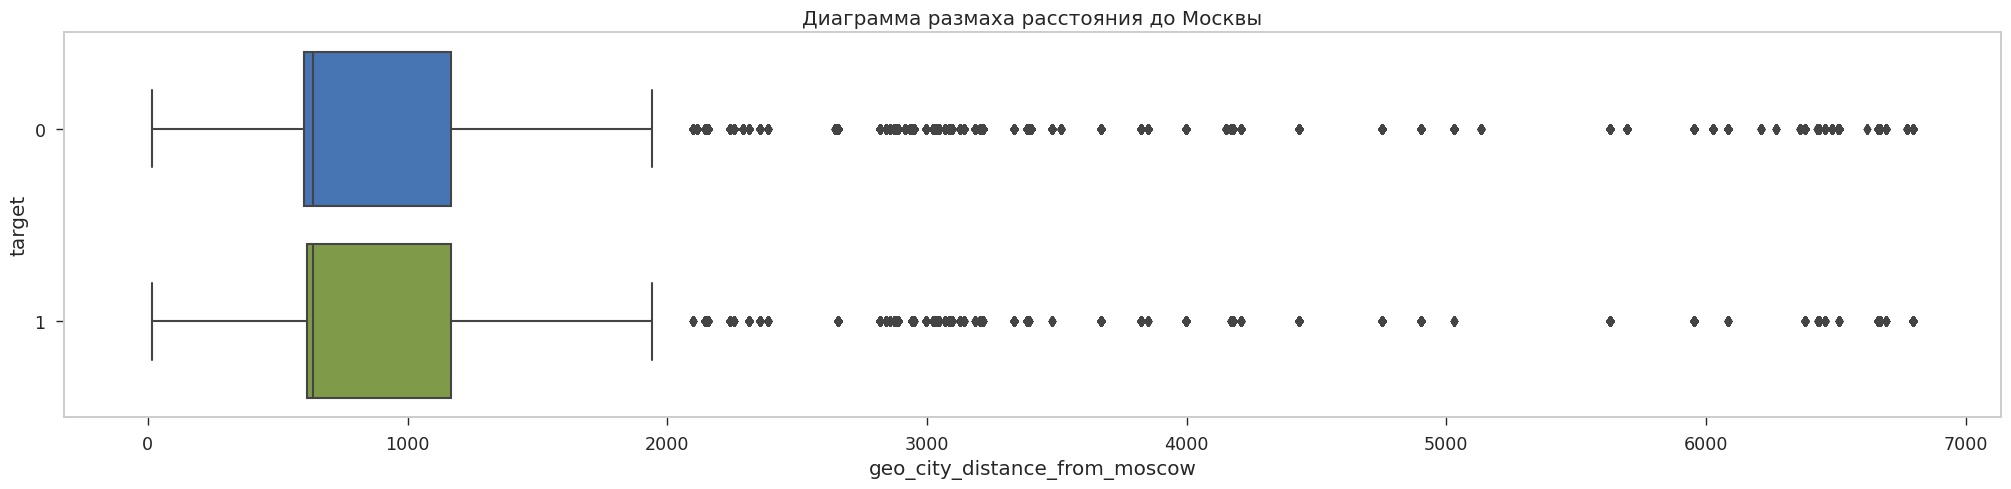

In [85]:
plt.figure(figsize=(25, 5))
positive_distances = df_session2[df_session2['geo_city_distance_from_moscow'] > 0]
sns.boxplot(data=positive_distances, x='geo_city_distance_from_moscow', 
            y='target', orient='h')
plt.title('Диаграмма размаха расстояния до Москвы');

In [86]:
def get_distance_category(distance: float) -> str:
    """Возвращает категорию расстояния до Москвы."""

    if distance == -1: return 'no distance'
    elif distance == 0: return 'moscow'
    elif distance < 100: return '< 100 km'
    elif distance < 500: return '100-500 km'
    elif distance < 1000: return '500-1000 km'
    elif distance < 3000: return '1000-3000 km'
    else: return '>= 3000 km'

df_session2['geo_city_distance_from_moscow_category'] = df_session2['geo_city_distance_from_moscow'].apply(get_distance_category)

In [87]:
print('Распределение объектов по расстоянию до Москвы:')
target_percentage(df_session2, 'geo_city_distance_from_moscow_category', 
                  index_name='Дистанция до Москвы')

Распределение объектов по расстоянию до Москвы:


,Количество объектов,Доля от общего числа,Процент целевых действий
Дистанция до Москвы,,,
moscow,5345451,43.50%,8.15%
1000-3000 km,1609696,13.10%,7.81%
< 100 km,719714,5.86%,7.72%
500-1000 km,2716911,22.11%,7.29%
no distance,749446,6.10%,7.05%
100-500 km,756814,6.16%,6.79%
>= 3000 km,390131,3.17%,6.36%


# **2. ПОИСК КОРРЕЛЯЦИЙ**

---


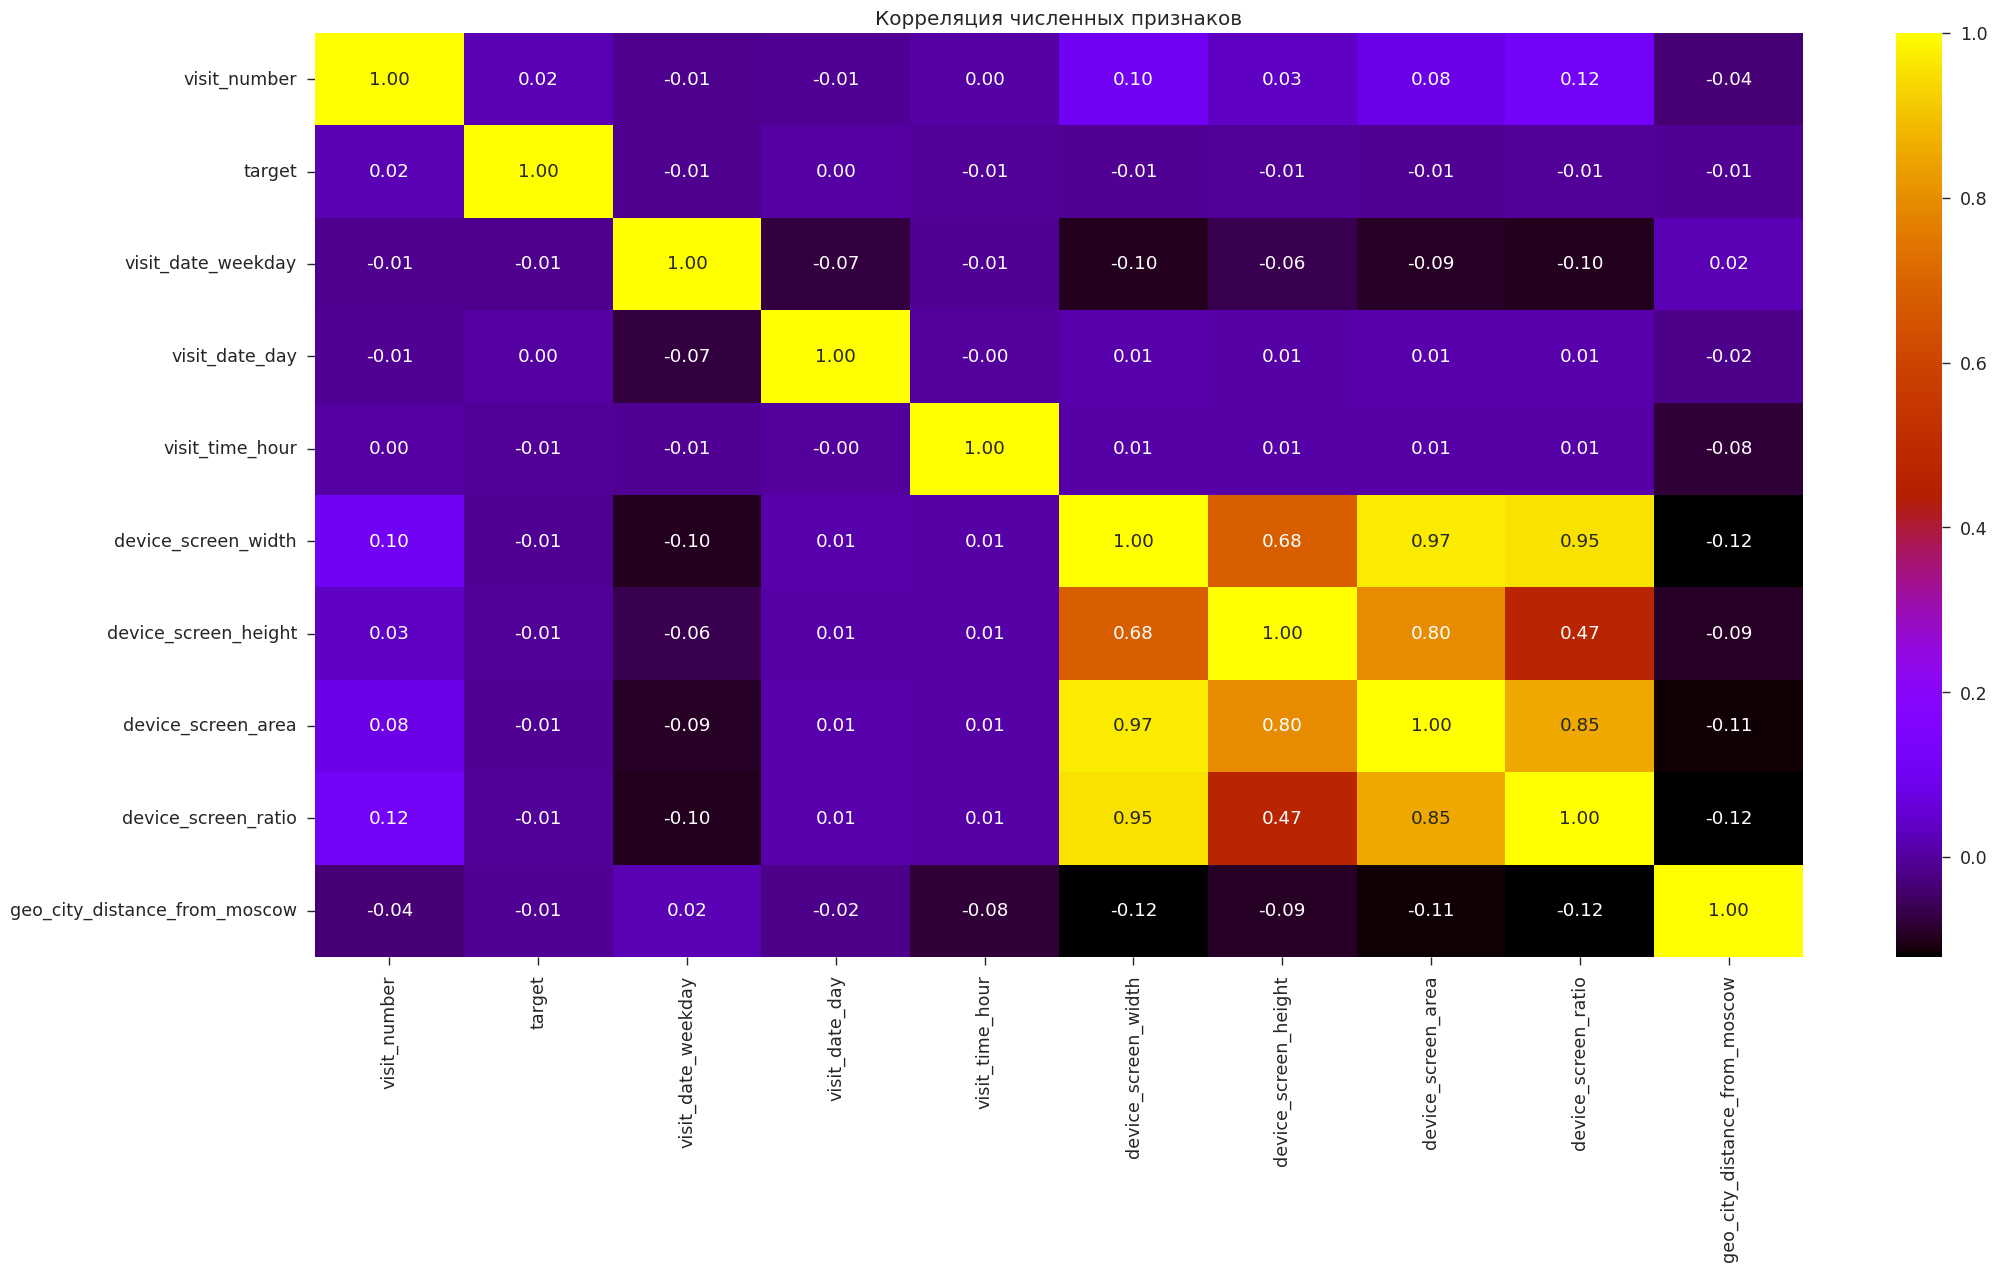

In [91]:
numerical_columns = [
   'visit_number', 'target', 'visit_date_weekday', 'visit_date_day', 
    'visit_time_hour', 'device_screen_width', 
    'device_screen_height', 'device_screen_area', 'device_screen_ratio', 
    'geo_city_distance_from_moscow']

plt.figure(figsize=(24,12))
sns.heatmap(df_session2[numerical_columns].corr(), annot=True, fmt='0.2f', cmap= 'gnuplot')
plt.title('Корреляция численных признаков');

Num_cols: 10


IndexError: index 10 is out of bounds for axis 0 with size 10

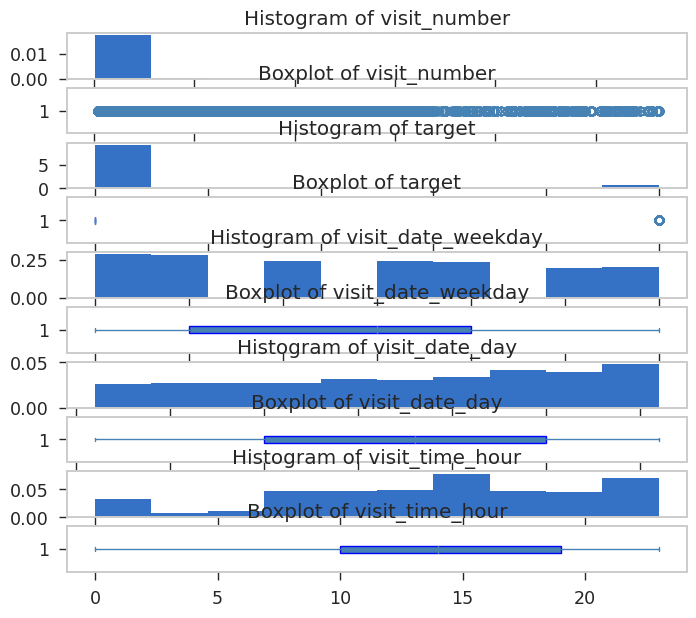

In [92]:
numeric_cols = numerical_columns
print(f'Num_cols: {len(numeric_cols)}')

rows_num = len(numeric_cols) 
fig, ax = plt.subplots(nrows=rows_num, ncols=1)
axes = ax.flatten()
i = 0

for col in numeric_cols:
    not_null_values = df_session2.loc[~df_session2[col].isnull(), col]     
    axes[i].hist(not_null_values, density=True, log=False)
    axes[i].set_title(f'Histogram of {col}')
    i += 1

    axes[i].boxplot(not_null_values, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='steelblue', color='blue'),
                    capprops=dict(color='steelblue'),
                    whiskerprops=dict(color='steelblue'),
                    flierprops=dict(color='steelblue', markeredgecolor='steelblue'),
                    medianprops=dict(color='steelblue'),
                   )
    axes[i].set_title(f'Boxplot of {col}')
    i += 1
        
for col in string_cols:
    not_null_values = df_session2.loc[~df_session2[col].isnull(), col]
    
    axes[i].hist(not_null_values, histtype='bar', bins=len(not_null_values.unique()))
    axes[i].set_title(f'Histogram of {col}')
    i += 1
    
fig.set_size_inches(18, 3 * len(string_cols))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show()

In [94]:

# удалим строки с 0
df_session2 = df_session2.dropna (subset=['device_screen_ratio'])
# проверим есть ли в конечном датасет строки с 0
print(df_session2.isna().sum())

visit_number                              0
utm_source                                0
utm_medium                                0
utm_campaign                              0
utm_adcontent                             0
device_category                           0
device_brand                              0
device_screen_resolution                  0
device_browser                            0
geo_country                               0
geo_city                                  0
target                                    0
car_brand                                 0
car_model                                 0
visit_date_weekday                        0
visit_date_month                          0
visit_date_weekend                        0
visit_date_day                            0
visit_time_hour                           0
visit_time_night                          0
device_screen_width                       0
device_screen_height                      0
device_screen_area              

In [96]:
# проверим на дубликаты. дубликатов нет 
df_session2[df_session2.duplicated()]
df_session2 = df_session2.drop_duplicates()
# проверим на дубликаты. дубликатов нет 
df_session2[df_session2.duplicated()]

,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,...,visit_time_hour,visit_time_night,device_screen_width,device_screen_height,device_screen_area,device_screen_ratio,geo_country_is_russia,geo_city_is_big,geo_city_distance_from_moscow,geo_city_distance_from_moscow_category
1,1,ZpYIoDJMcFzVoPFsHGJL,banner,ZpYIoDJMcFzVoPFsHGJL,ZpYIoDJMcFzVoPFsHGJL,mobile,Huawei,360x720,Chrome,Russia,...,2,True,360,720,259200,0.500000,True,True,3336.03975,>= 3000 km
2,1,ZpYIoDJMcFzVoPFsHGJL,banner,ZpYIoDJMcFzVoPFsHGJL,ZpYIoDJMcFzVoPFsHGJL,mobile,Huawei,360x720,Chrome,Russia,...,2,True,360,720,259200,0.500000,True,True,3336.03975,>= 3000 km
3,1,ZpYIoDJMcFzVoPFsHGJL,banner,ZpYIoDJMcFzVoPFsHGJL,ZpYIoDJMcFzVoPFsHGJL,mobile,Huawei,360x720,Chrome,Russia,...,2,True,360,720,259200,0.500000,True,True,3336.03975,>= 3000 km
4,1,ZpYIoDJMcFzVoPFsHGJL,banner,ZpYIoDJMcFzVoPFsHGJL,ZpYIoDJMcFzVoPFsHGJL,mobile,Huawei,360x720,Chrome,Russia,...,2,True,360,720,259200,0.500000,True,True,3336.03975,>= 3000 km
5,1,ZpYIoDJMcFzVoPFsHGJL,banner,ZpYIoDJMcFzVoPFsHGJL,ZpYIoDJMcFzVoPFsHGJL,mobile,Huawei,360x720,Chrome,Russia,...,2,True,360,720,259200,0.500000,True,True,3336.03975,>= 3000 km
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12288158,1,fgymSoTvjKPEgaIJqsiH,cpm,fgymSoTvjKPEgaIJqsiH,fgymSoTvjKPEgaIJqsiH,desktop,Apple,1366x768,Chrome,Russia,...,19,False,1366,768,1049088,1.778646,True,True,0.00000,moscow
12288159,1,fgymSoTvjKPEgaIJqsiH,cpm,fgymSoTvjKPEgaIJqsiH,fgymSoTvjKPEgaIJqsiH,desktop,Apple,1366x768,Chrome,Russia,...,19,False,1366,768,1049088,1.778646,True,True,0.00000,moscow
12288160,1,fgymSoTvjKPEgaIJqsiH,cpm,fgymSoTvjKPEgaIJqsiH,fgymSoTvjKPEgaIJqsiH,desktop,Apple,1366x768,Chrome,Russia,...,19,False,1366,768,1049088,1.778646,True,True,0.00000,moscow
12288161,1,fgymSoTvjKPEgaIJqsiH,cpm,fgymSoTvjKPEgaIJqsiH,fgymSoTvjKPEgaIJqsiH,desktop,Apple,1366x768,Chrome,Russia,...,19,False,1366,768,1049088,1.778646,True,True,0.00000,moscow


In [100]:
# запишем фин файл для моделирования
path = os.path.expanduser('~/PycharmProjects/FinalFantasyProj/')
df_session2.to_csv(path + 'df_sessions_prepared_for_modelling.csv', index=False)

# **3. ВЫВОДЫ**

---
Сервис "СберАвтоподписка" - новый продукт, потому, клинты его тщательно изучают. Только 7.68 % сессий завершилось целевым действием.

Наблюдения:

В дневное время и в первой половине недели больше всего производится целевых действий.
Чем больше раз пользователь посещает сайт, тем скорее он совершит целевое действие.
В топах по выбору авто стоят volkswagen, mercedes-benz, nissan, skoda, bmw, lada-vaz, kia
